> This script performs exploration of the data. <br>
> Sources:
  
> Master file `mapped-lcia-results.xlsx` containing:
>  * in Sheet1: LCIA results of interest mapped against the data from EI35APOS (volumes, prices, etc.)  
>  * in lcia_methods sheet: the names of the LCIA methods

Note:
> `mapped-lcia-results.xlsx` file was generated in `0.02-vt-map-lcia-results-to-sp910-and-ei35apos-processes.ipynb`

In [ ]:
# %env
# %who_ls
# %who
# %who int
# %pinfo <var name>

### Import basic libraries and funtions

In [ ]:
%config IPCompleter.use_jedi = False # disable jedi autocompleter (https://stackoverflow.com/a/65734178/14485040)

import project_path  # makes possible the access to `src` directory using relative path
from src.data import (
    create_glo_market,
    filter_dataframe,
    internal_funcs,
    outlier_detectors,
)
from src.utils import explore_dir, make_readme_info, progressbar
from src.utils import read_excel_to_pandas as r_excel
from src.utils import set_outputs_dir
from src.utils import write_pandas_to_excel as w_excel
from src.visualization import (
    calculate_stats,
    create_fig,
    fix_hist_cdf_drop_line_at_end,
    linear_regr,
    turn_to_scientific,
)

%run init_nb.ipynb

# Prepare data

## Read and pretreat extracted data

### Identify file(s) to read

In [ ]:
# Explore the directory to find the file(s)

inputs_dir, files_list = explore_dir(
    path_to_dir=r"..\data\interim", file_extension="xlsx", print_files_list=True
)

from pathlib import Path; import os # temp

# Set output directory
outputs_dir = set_outputs_dir(
    use_default=False, rel_path_output=r"..\data\interim\figs"
)

# Sub-folders
pngFilesDir = outputs_dir/'png_files' # full path to folder w/png files
svgFilesDir = outputs_dir/'svg_files' # full path to folder w/svg files

# Generate required folders if needed
if not Path.exists(pngFilesDir):
    os.mkdir(pngFilesDir)
if not Path.exists(svgFilesDir):
    os.mkdir(svgFilesDir)

### - read master file to df (raw)

<div class="alert alert-block alert-danger">
    <h3> pending (possible) improvements: </h3>


1. FIND WITH A REGULAR EXPRESSION! # THE PATTERN IS THE TUPLE LIKE NAMING OF THE METHODS !!!


</div>

In [ ]:
# Process raw data

# Master df with raw data
df_master_raw = r_excel(inputs_dir, "mapped-lcia-results.xlsx", sheets="Sheet1")
print(
    "df of the master data (raw) ".ljust(40, "."),
    f"{df_master_raw.shape}\n".rjust(13, "."),
)

# Get unique names of the LCIA methods
lcia_methods = r_excel(inputs_dir, "mapped-lcia-results.xlsx", sheets="lcia_methods")[
    "Method"
].values.tolist()

print("Unique names of LCIA methods ({} in total):".format(len(lcia_methods)))
print(
    "".join(map('\n\t"{}", '.format, lcia_methods))
)  # unique method names from all the workbooks

### - drop redundant and unnecessary columns
<div class="alert alert-block alert-info">
created: <strong>df_analysis_prev</strong>
</div>

#### -- 1. identify columns w/ method labels and list "non-method" columns

In [ ]:
# a. select all the methods, make a dictionary
"""creates a dictionary -> {'method': [method labels in df]}
        {'method1': ["('method1', 'category1', 'unit1')", "('method1', 'category2', 'unit2')", ...], 
         'method2': [...]
"""
dict_fullMethods = {}

for method in lcia_methods:
    lst = []
    for label in df_master_raw.columns:
        if method in label:
            lst.append(label)
    dict_fullMethods.setdefault(method, []).extend(
        lst
    )  # should be .extend() ! not .append()

# b. flat list of df's labels corresponding to a method
lst_all_method_labels = [
    value for key in dict_fullMethods.keys() for value in dict_fullMethods[key]
]
# (an alternative) [item for sublist in list(dict_fullMethods.values()) for item in sublist]
print(
    "df_master_raw (consisting of {} columns) contains a list of {} methods."
    "\n\nHere is a sample of 3 randomly shown methods:"
    "\n\t- {}\n\t- {}\n\t- {}"
    "\n\n*Check the full list of methods by printing 'lst_all_method_labels',\n"
    "or using 'dict_fullMethods' dictionary with keys in 'lcia_methods'.".format(
        len(df_master_raw.columns),
        len(lst_all_method_labels),
        *random.sample(lst_all_method_labels, 3)
    )
)
# c. rest of the columns in df_master_raw
rest_of_columns = [col for col in df_master_raw.columns if col not in lst_all_method_labels]
print(
    "\nThe rest of the {} columns, shown below, "
    "may contain redundant or unnecessary information,"
    "\nfill free to select only required columns.".format(
        len(rest_of_columns)
    )
)
print("".join(map('\n\t"{}", '.format, rest_of_columns)))

#### -- 2. select columns w/ non-method labels
<div class="alert alert-block alert-danger">
     <h5> ``lst_metadata`` has to be populated manually ❗ </h5>
</div>

In [ ]:
# 2. Pick from the rest of the columns
print(df_master_raw[rest_of_columns].nunique())

# list of df's non-method labels (select manually from the list printed above)
lst_metadata = [
    "Activity",
    "activity_comment",
    "type",
    "referenceProduct",
    "category",
    "inline_comment",
    # 👆🏼 above columns are originally from _SP,
    # 👇🏼 below from _EI
    "geo",
    "activity_ISICclass",
    "activity_ecoSpold01class",
    "technologyLevel",
    "referenceProductAmount",
    "referenceProductUnit",
    "referenceProduct_prodVolume",
    "referenceProduct_prodVolumeComment",
    "referenceProduct_price",
    "referenceProduct_priceUnit",
    "referenceProduct_priceComment",
    "referenceProduct_casNumber",
    "referenceProduct_CPCclass",
    "activity_generalComment",
    "sourceFilename",
]
print(
    "\nTotal ºn of non-method columns (above) is {}, you selected {} of them.".format(
        len(rest_of_columns), len(lst_metadata)
    )
)

#### -- 3. select columns w/ method labels
<div class="alert alert-block alert-danger">
     <h5> ``lst_methods`` is generated here 👇🏼</h5>
     lst_methods will be used throughout the script for calculations and plotting
</div>

In [ ]:
# lst_all_method_labels # here is the complete list of methods per category if needed
print("Here is the list of method names (again): ")
print("".join(map('\n\t"{}", '.format, lcia_methods)))

In [ ]:
# select from method names printed above
select_keys = [
    "IPCC 2013 GWP 100a V1.03",
    "PBs-LCIA (baseline) V0.72",
]  # change manually if needed

lst_methods = []
for key in select_keys:
    lst_methods += dict_fullMethods[key]
print("{} methods have been selected:".format(len(lst_methods)))
del select_keys
lst_methods

#### -- 4. Generate ``analysis_prev`` df (and delete ``df_master_raw`` ?)

In [ ]:
df_master_raw.filter(items=lst_metadata + lst_methods, axis=1).sort_values(
    by="Activity", inplace=False
)

In [ ]:
# 3. Combine steps 2 and 3

df_analysis_prev = df_master_raw.loc[:, list(lst_metadata + lst_methods)].copy()
df_analysis_prev.sort_values(by="Activity", inplace=True)

# del df_master_raw # delete to free memory
pd.options.display.max_columns = None

print("Created **df_analysis_prev** dataframe is of {} shape.".format(df_analysis_prev.shape))
df_analysis_prev.sample(5)

### - add data with chemical properties (from PubChem)
<div class="alert alert-block alert-info">
    created: <strong>df_properties</strong> (based on unique items of <strong>df_analysis_prev</strong>) <br><br>
    created: <strong>df_analysis</strong>
</div>

<div class="alert alert-block alert-warning">
<h4 class="alert-heading">WARNING ❗</h4>
    This step is <strong>time consuming</strong> due to the API restriction of PubChem database. <br>
    The code below will be inactive by default, the extracted data can be also imported from an Excel file.
</div>

In [ ]:
df_analysis_prev[df_analysis_prev.referenceProduct == "Nylon 6-6"]

# for "Nylon 6-6" to be found in PubChem, CAS number has to be included (as found in cirpy, below).
# add CAS number "52349-42-5" to reference product "Nylon 6-6"
df_analysis_prev.loc[df_analysis_prev.referenceProduct == "Nylon 6-6", "referenceProduct_casNumber"] = "52349-42-5"

df_analysis_prev[df_analysis_prev.referenceProduct == "Nylon 6-6"]

#### --- query PubChem database (deactivated by default)

In [ ]:
# %%time
# df_properties = get_properties_from_pubchem(
#     df=df_analysis_prev.drop_duplicates(subset=["referenceProduct", "referenceProduct_casNumber"]),
#     cas_column="referenceProduct_casNumber",
#     name_column="referenceProduct",
# )
# df_properties.reset_index(inplace=True)
# df_properties.rename(columns={"index":"referenceProduct"}, inplace=True)

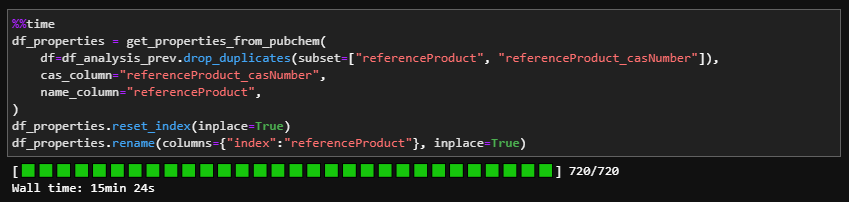

#### --- export to excel (activate if previous cell is active)

In [ ]:
# ## Export dataframe to excel
# excelName = "df_chemproperties.xlsx"

# df_readme = readme_data(
#     excelName,
#     "Dataframe with chemical properties for unique reference products from df_analysis_prev. \n"
#     "Chemical properties were retrieved from PubChem database.",
# ) 

# writedf_to_Excel(
#     path_to_file=outputsDir,
#     filename=excelName,
#     sheetname_and_data={"Sheet1": df_properties}, 
#     readme_data={"readme":df_readme},
# #     ExcelWriter_kwargs={"engine": "openpyxl", "encoding": "UTF-8"}
# #     startrow=0
# )

#### --- backup read from excel (deactivate if previous 2 cells are active)

In [ ]:
# df with chemical properties
df_properties = r_excel(inputs_dir, "df_chemproperties.xlsx", sheets="Sheet1")
print(
    "df of chemical properties data (raw) ".ljust(40, "."),
    f"{df_properties.shape}\n".rjust(13, "."),
)

In [ ]:
df_properties.sort_values(by=["MW", "pubchem_match"], ascending=True, inplace=True)
df_properties.sample(3)

In [ ]:
percent_not_matched = (
    1
    - df_properties[df_properties.num_matches != 0].referenceProduct.count()
    / df_properties.referenceProduct.count()
) * 100
print("{}% of referenceProducts had no match...".format(percent_not_matched.round(2)))

#### --- **explore df_properties

In [ ]:
# df_properties[df_properties.num_matches == 0]

In [ ]:
df_properties[df_properties.num_matches == 0]

In [ ]:
# Components not identified automatically by PubChem
# have to be added manually !
comp_added_manually = [
    # from Javier's list
    "Liquefied petroleum gas",
    "Petrol, low-sulfur",  # or 'Petrol, unleaded',
    "Diesel",
    "Diesel, low-sulfur",
    "Kerosene",
    # other
    "Xylene",  # o-, m- or p-
]
comp_added_manually

In [ ]:
# Properties added here, 
# if desired, specific MW and complexity and other can be added below

df_properties.loc[
    df_properties.referenceProduct == "Liquefied petroleum gas",
    ["pubchem_match", "num_matches", "MW"],
] = ["manual match", 1, 44.097] # Propane MW used as proxy

df_properties.loc[
    df_properties.referenceProduct == "Petrol, low-sulfur",
    ["pubchem_match", "num_matches", "MW"],
] = ["manual match", 1, 105] # MW taken as average...

df_properties.loc[
    df_properties.referenceProduct == "Diesel",
    ["pubchem_match", "num_matches", "MW"],
] = ["manual match", 1, 200] # MW taken as average...

df_properties.loc[
    df_properties.referenceProduct == "Diesel, low-sulfur",
    ["pubchem_match", "num_matches", "MW"],
] = ["manual match", 1, 200] # MW taken as average...

df_properties.loc[
    df_properties.referenceProduct == "Kerosene",
    ["pubchem_match", "num_matches", "MW"],
] = ["manual match", 1, 170] # MW taken as average...

df_properties.loc[
    df_properties.referenceProduct == "Xylene",
    ["pubchem_match", "num_matches", "MW"],
] = ["manual match", 1, 106]

for item in comp_added_manually:
    if df_properties.loc[df_properties.referenceProduct == item, ["pubchem_match"]].values[0] == "No match":
        df_properties.loc[
            df_properties.referenceProduct == item, ["pubchem_match", "num_matches", "MW"],
        ] = ["manual match", 1, 100] # dummy MW

In [ ]:
filter_dataframe(
    df_in=df_properties,
    col_name="referenceProduct",
    filter_in=comp_added_manually,
    exact_match=True,
    print_unique=True,
)

In [ ]:
percent_not_matched = (
    1
    - df_properties[df_properties.num_matches != 0].referenceProduct.count()
    / df_properties.referenceProduct.count()
) * 100
print("{}% of referenceProducts had no match...".format(percent_not_matched.round(2)))

<div class="alert alert-block alert-warning"> 
❗❗❗ <br>
    the cas number of "Praseodymium oxide" is not found in the PubChem database, <br>
    but could be found in Sigma-Aldrich (which references to a compound name in PubChem -> "Praseodymium (III, IV) oxide"). <br>
    <strong>Change the name to make it searchable in PubChem...</strong> 
</div>

In [ ]:
lst_casNotFound = list(df_properties[df_properties.num_matches == 0].referenceProduct)
e, *_ = lst_casNotFound[0].split(", ")
print("{} not matched reference products".format(len(lst_casNotFound)))
lst_casNotFound

In [ ]:
crp.resolve("Anhydrite", "iupac_name")

In [ ]:
crp.query("Krypton", "iupac_name")

In [ ]:
c = pcp.get_compounds("EINECS 222-037-3", namespace="name", searchtype=None, as_dataframe=False)
print(c[0].molecular_formula)
print(c[0].molecular_weight)

In [ ]:
from cirpy import Molecule

mol = Molecule("Nylon 6/6")
print(mol.cas)
print(mol.formula)
print(mol.mw)
print(mol.image_url)
print(mol.names)

In [ ]:
c = pcp.get_compounds("52349-42-5", namespace="name", searchtype=None, as_dataframe=False)
print(c[0].molecular_formula)
print(c[0].molecular_weight)

In [ ]:
indices_casNotFound = [
    idx
    for idx in df_analysis_prev.index
    if df_analysis_prev.referenceProduct[idx] in lst_casNotFound
]
print("{} not matched reference products in df_analysis_prev".format(len(indices_casNotFound)))
# indices_casNotFound

In [ ]:
df_analysis_prev.columns

In [ ]:
df_to_explore = df_analysis_prev.loc[indices_casNotFound][
    lst_metadata
    #     [
    #         "Activity",
    #         "category",
    #         "referenceProduct_CPCclass",
    #         "referenceProduct",
    #         "referenceProduct_prodVolume",
    #         "wasteType",
    #         "geo",
    #         "referenceProductUnit",
    #         "referenceProduct_casNumber",
    #     ]
].sort_values(
    by=["referenceProduct_prodVolume", "category"]
)  # .category.unique()  # .sort_index()

# df_to_explore
# sorted(
#     filter_dataframe(
#         _filter_by_geo_and_FU(df_to_explore, geo="GLO", FU="kg"),
#         col_name="referenceProduct_CPCclass",
#         filter_in=["3"],
#     ).Activity,  # .referenceProduct_CPCclass
#     reverse=False,
# )


lst_temp = []

for idx in internal_funcs.filter_by_geo_and_fu(
    df_to_explore, geo="GLO", funit="kg"
).index:
    x = df_to_explore.referenceProduct_CPCclass[idx]
    if (
        str(x).startswith("33")
        or str(x).startswith("34")
        or str(x).startswith("35")
        or str(x).startswith("36")
    ):
        lst_temp.append(df_to_explore.Activity[idx])
sorted(lst_temp)

In [ ]:
# find = 'Stone meal'
# find = "Horn meal"
find = "Polyvinylfluoride, dispersion"

print(list(df_analysis_prev[df_analysis_prev.referenceProduct==find].activity_comment),"\n")
print(list(df_analysis_prev[df_analysis_prev.referenceProduct==find].inline_comment),"\n")
print(list(df_analysis_prev[df_analysis_prev.referenceProduct==find].referenceProduct_prodVolumeComment),"\n")
print(list(df_analysis_prev[df_analysis_prev.referenceProduct==find].referenceProduct_priceComment),"\n")
print(list(df_analysis_prev[df_analysis_prev.referenceProduct==find].activity_generalComment),"\n")

df_analysis_prev[df_analysis_prev.referenceProduct==find]

#### --- created ``df_analysis``

In [ ]:
df_analysis = df_analysis_prev.merge(df_properties, how="left", on="referenceProduct")


# (!) update the list of non-method column labels
prop_list = list(
    filter(
        lambda a: "referenceProduct" not in a and "cas" not in a, df_properties.columns
    )
)
lst_metadata = [i for i in lst_metadata if i not in prop_list]
lst_metadata = lst_metadata + prop_list
# # ---------------
df_analysis = df_analysis.loc[:, list(lst_metadata + lst_methods)]
print("Created **df_analysis** dataframe is of {} shape.\n".format(df_analysis.shape))
df_analysis.sample(3)

#### -- export to excel (activate if required)

In [ ]:
# ## Export dataframe to excel
# excelName = "df_to_analyze.xlsx"

# df_readme = readme_data(
#     excelName,
#     "Dataframe with combined chemical markets, "
#     "their (selected) metadata and scores for multiple LCIA methods. Ready to be analyzed."
#     "(columns with chemical properties included)",
# ) 

# writedf_to_Excel(
#     path_to_file=outputsDir,
#     filename=excelName,
#     sheetname_and_data={"Sheet1": df_analysis}, 
#     readme_data={"readme":df_readme},
# #     ExcelWriter_kwargs={"engine": "openpyxl", "encoding": "UTF-8"}
# #     startrow=0
# )

### - Data filtering and regrouping
<div class="alert alert-block alert-info">
filter the df using CPC classification <strong>(only 3.3 to 3.6 categories)</strong>
</div>

In [ ]:
regrouped_cat = []
for item in df_analysis.index:
    if str(df_analysis.referenceProduct_CPCclass[item]).startswith("33"):
        regrouped_cat.append(
            "33: Coke oven products; refined petroleum products; nuclear fuel"
        )
    elif str(df_analysis.referenceProduct_CPCclass[item]).startswith("34"):
        regrouped_cat.append("34: Basic chemicals")
    elif str(df_analysis.referenceProduct_CPCclass[item]).startswith("35"):
        regrouped_cat.append("35: Other chemical products; man-made fibres")
    elif str(df_analysis.referenceProduct_CPCclass[item]).startswith("36"):
        regrouped_cat.append("36: Rubber and plastics products")
    else:
        regrouped_cat.append("Other product (not in CPC: 33-36 divisions)")

try:
    df_analysis.insert(1, "category_regrouped", regrouped_cat, allow_duplicates=False)
except:
    df_analysis.drop("category_regrouped", axis=1, inplace=True)
    df_analysis.insert(1, "category_regrouped", regrouped_cat)


# (!) update the list of non-method column labels
lst_metadata = list(filter(lambda a: a != "category_regrouped", lst_metadata))
lst_metadata.insert(1, "category_regrouped")
print("Updated **df_analysis** dataframe is of {} shape.\n".format(df_analysis.shape))
df_analysis.sample(2)

internal_funcs.plot_categories(
    df_in=df_analysis,
    groupby="category_regrouped",    
    color="gray", 
    fontsize=12,
    cutoff_value=8,
)

In [ ]:
# df_analysis[
#     df_analysis.category_regrouped.isin(
#         [
# #             "36: Rubber and plastics products",
#             "Other product (not in CPC: 33-36 divisions)",
#         ]
#     )
# ]

In [ ]:
# drop all activities not from CPC 33-36
df_base_CPC33to36 = filter_dataframe(
    df_analysis,
    col_name="category_regrouped",
    filter_out=[
        "Other product (not in CPC: 33-36 divisions)",
#         "36: Rubber and plastics products",
    ],
)
print(
    "Created **df_base_CPC33to36** dataframe is of {} shape.\n".format(
        df_base_CPC33to36.shape
    )
)
# df_base_CPC33to36.sample(3)

internal_funcs.plot_categories(
    df_in=df_base_CPC33to36,
    groupby="category_regrouped",
    color="gray",
    fontsize=12,
    cutoff_value=8,
)

In [ ]:
internal_funcs.plot_categories(
    df_base_CPC33to36,
    groupby="category_regrouped",
    cutoff_value=0,
    color="purple",
    fontsize=12,
)

In [ ]:
regrouped_cat = []
for item in df_base_CPC33to36.index:
    if str(df_base_CPC33to36.referenceProduct_CPCclass[item]).startswith(
        ("331", "332", "333", "334", "335", "341", "343", "347", "352", "36")
    ):
        regrouped_cat.append("Organic chemical")
    elif str(df_base_CPC33to36.referenceProduct_CPCclass[item]).startswith(("342", "344")):
        regrouped_cat.append("Inorganic chemical")
    else:
        regrouped_cat.append("Other chemical")


try:
    df_base_CPC33to36.insert(1, "category_regrouped", regrouped_cat, allow_duplicates=False)
except:
    df_base_CPC33to36.drop("category_regrouped", axis=1, inplace=True)
    df_base_CPC33to36.insert(1, "category_regrouped", regrouped_cat)


# (!) update the list of non-method column labels
lst_metadata = list(filter(lambda a: a != "category_regrouped", lst_metadata))
lst_metadata.insert(1, "category_regrouped")

df_base_CPC33to36.sample(2)

internal_funcs.plot_categories(
    df_base_CPC33to36,
    groupby="category_regrouped",
    cutoff_value=0,
    color="purple",
    fontsize=12,
)

In [ ]:
print(
    "before creating new GLO markets, there are {} GLO markets with FU=1kg belonging to CPC 33-36 in the database.".format(
        df_base_CPC33to36[
            (df_base_CPC33to36.geo == "GLO")
            &
            (df_base_CPC33to36.referenceProductUnit == "kg")
        ].shape[0]
    )
)

In [ ]:
prueba = list(df_base_CPC33to36[
            (df_base_CPC33to36.geo != "GLO")
            &
            (df_base_CPC33to36.referenceProductUnit == "kg")
        ].referenceProduct.unique())
prueba2 = list(df_base_CPC33to36[
            (df_base_CPC33to36.geo == "GLO")
            &
            (df_base_CPC33to36.referenceProductUnit == "kg")
        ].referenceProduct.unique())

In [ ]:
# [i for i in prueba2 if i in prueba]

In [ ]:
# df_base_CPC33to36[df_base_CPC33to36.referenceProduct.isin(["Diesel", "Diesel, low-sulfur"])]

In [ ]:
df_base_CPC33to36.columns

In [ ]:
%%time
# WHAT ARE THE OTHER CHEMICALS? DO THEY BELONG TO ORGANIC OR INORGANIC???
# CHECK LATER!

df_toprint = df_base_CPC33to36[df_base_CPC33to36.category_regrouped == "Other chemical"][
    [
        "referenceProduct",
        "MF",
        "category_regrouped",
        "referenceProduct_CPCclass",
        "category",
        "Activity",
    ]
]

outdir = set_outputs_dir(use_default=True) # set to default "..\data\interim"
flname = "CPC33to36_other_chemicals.xlsx"
rdme = make_readme_info(flname, "Chemicals alternatively classifed as 'other'."
            "The chemicals have to be checked and probably moved to organic or inorganic...")
w_excel(
    path_to_file=outdir,
    filename=flname,
    dict_data_to_write={"sheet1": df_toprint},
    readme_info=('readme', rdme)
)
df_toprint.sample(3)

In [ ]:
# checking numbers

# df_base_CPC33to36[
#     (df_base_CPC33to36.geo != "GLO")
#     & 
#     (df_base_CPC33to36.referenceProductUnit == "kg")
# ].shape

# 414 NON GLO MARKETS WITH FU "KG" ARE COMBINED INTO 192 NEW GLO MARKETS BELOW!!!

#### -- export to excel (activate if required)

In [ ]:
# ## Export dataframe to excel
# excelName = "df_base_CPC33to36.xlsx"

# df_readme = readme_data(
#     excelName,
#     "Filtered dataframe includes only GLO chemical markets with FU = 1kg "
#     "which pertain to CPC divisions 33, 34 , 35 or 36. "
#     "[This df includes the outliers and the chemicals w/o identified chemical properties, "
#     "both of which are removed in df_clean]"
# )

# writedf_to_Excel(
#     path_to_file=outputsDir,
#     filename=excelName,
#     sheetname_and_data={"Sheet1": df_base_CPC33to35}, 
#     readme_data={"readme":df_readme},
# #     ExcelWriter_kwargs={"engine": "openpyxl", "encoding": "UTF-8"}
# #     startrow=0
# )

### - Create mass allocated GLO markets from non-GLO markets
<div class="alert alert-block alert-info">
created: <strong>df_analysis_extended</strong>
</div>

In [ ]:
df_analysis_extended = create_glo_market(
    df_in=df_base_CPC33to36,
    columns_to_allocate=lst_methods,
    activity_column="Activity",
    refprod_column="referenceProduct",
    geo_column="geo",
    prodvol_column="referenceProduct_prodVolume",
    comment_column="activity_generalComment",
)

print("Created **df_analysis_extended** dataframe is of {} shape.".format(df_analysis_extended.shape))
df_analysis_extended.tail(2)

internal_funcs.plot_categories(
    df_analysis_extended,
    groupby="category_regrouped",
    cutoff_value=0,
    color="purple",
    fontsize=12,
)

#### Checks!

In [ ]:
filter_dataframe(
    df_in=df_analysis_extended,
    col_name="referenceProduct",
    filter_in=comp_added_manually,
#     filter_in=["Diesel"],
    exact_match=True,
)

# list(df_analysis_extended[df_analysis_extended.Activity=="Diesel, combined to GLO market"].activity_generalComment)

#### -- export to excel (activate if required)

In [ ]:
# ## Export dataframe to excel
# excelName = "df_to_analyze_extended_GLOmarkets.xlsx"

# df_readme = readme_data(
#     excelName,
#     "Dataframe similar to df_to_analyze.xlsx [(selected) metadata of chemical markets and scores for multiple LCIA methods], but with additional GLO chemical markets, obtained from mass allocation of respective non-GLO markets.",
# )

# writedf_to_Excel(
#     path_to_file=outputsDir,
#     filename=excelName,
#     sheetname_and_data={"Sheet1": df_analysis_extended}, 
#     readme_data={"readme":df_readme},
# #     ExcelWriter_kwargs={"engine": "openpyxl", "encoding": "UTF-8"}
# #     startrow=0
# )

#### Checks

In [ ]:
# lst_all_method_labels

In [ ]:
# Check if items in potentially duplicated columns are the same
any(
    ~(df_master_raw.shortName_geo == df_master_raw.geo)
)  # any not equal items in both columns?
any(
    ~(df_master_raw.fullName_SimaPro == df_master_raw.Activity)
)  # any not equal items in both columns?
any(
    ~(df_master_raw.unit == df_master_raw.referenceProductUnit)
)  # any not equal items in both columns?
any(
    ~(df_master_raw.amount == df_master_raw.referenceProductAmount)
)  # any not equal items in both columns?

In [ ]:
# checks: are the column values identical? ---> redundant
all(df_master_raw.unit == df_master_raw.referenceProductUnit)

In [ ]:
# filter_dataframe(df_master_raw, 'unit_intExchange', filter_out=['kg'])

## Created dfs to work with: `df_base_full` and `df_base_full_wCAS`

#### create df_base only with GLO markets and individual FU=kg

In [ ]:
df_base = df_analysis_extended[
    (df_analysis_extended.geo == "GLO")
    & (df_analysis_extended.referenceProductUnit == "kg")
]# .shape


# # Group by shortName_geo_SP -> filter by GLO -> Filter "unit" by "kg"
# df_base = _filter_by_geo_and_FU(
# #     df=df_analysis,
#     df=df_analysis_extended,
#     geo="GLO", 
#     FU="kg"
# )
print("Created **df_base** dataframe is of {} shape.\n".format(df_base.shape))
# df_base

# Grouping by 'category' and ploting the size of each group on a barh plot (in one line)
internal_funcs.plot_categories(
    df_in=df_base,
    groupby="category_regrouped",   
    color="blue", 
    fontsize=12,
    cutoff_value=8,
)

In [ ]:
# Products excluded from the analysis
internal_funcs.excluded_products(
    df_raw=df_analysis_extended, # or =df_analysis_extended, (both have the same nº of unique products)
    df_filtered=df_base
)

#### add transgression levels (TLs) to df_base
<div class="alert alert-block alert-warning">
created: <strong>df_base_full and df_base_full_wCAS</strong>  
</div> 

In [ ]:
# correct methods name for TLs... add lst_methods_TLs
lst_methods_TLs = lst_methods_TLs = ["TL in " + sub for sub in lst_methods[1:]]
lst_methods_TLs

##### create `df_base_full` with ALL activities

In [ ]:
df_base_full = pd.concat(
    [
        df_base,
        calculate_TL_PBs(
            df_base,
            method_labels=lst_methods[1:],
            price_column="referenceProduct_price",
            GVA_world = 7.38e13, # in 2018
            correctGVA=None,
#             correctGVA="sales",
#             correctGVA="purchases",
#             share_of_SOS=0.0689, # aggregated shares of 4 sectors (C19-22) using GGG method
#             share_of_SOS=0.0237, # only C20 sector using GGG method
#             share_of_SOS=0.0274, # aggregated shares of 4 sectors (C19-22) using WIOD with L inverse
#             share_of_SOS=0.0076, # only C20 sector using WIOD with L inverse
        ).add_prefix("TL in "),
    ],
    axis=1,
)
print("Created **df_base_full** dataframe is of {} shape.\n".format(df_base_full.shape))
df_base_full.tail(5)

In [ ]:
# convert prices from EUR2005 to USD2018
# using this unit the TLs were calculated !!!
PPI_2018 = 104.5 # Producer Price Index from Eurostat
PPI_2005 = 86.0  # Producer Price Index from Eurostat
USD_per_EUR_2018 = 1.1811 # average exchange rate EUR to USD in 2018

df_base_full.referenceProduct_price = (df_base_full.referenceProduct_price * PPI_2018 / PPI_2005) * USD_per_EUR_2018
df_base_full.referenceProduct_priceUnit = "USD2018"
df_base_full.sample(2)

In [ ]:
# Grouping by 'category_regrouped' and ploting the size of each group on a barh plot (in one line)
internal_funcs.plot_categories(
    df_in=df_base_full,
    groupby="category_regrouped",
    color="green",
    fontsize=12,
)

In [ ]:
df_base_full[df_base_full.referenceProduct == 'Cyclic N-compound']

In [ ]:
# ## Export dataframe to excel
# excelName = "df_base_full.xlsx"

# df_readme = readme_data(
#     excelName,
#     "Dataframe df_base_full - all GLO markets with PBs and TLs.",
# )

# writedf_to_Excel(
#     path_to_file=outputsDir,
#     filename=excelName,
#     sheetname_and_data={"Sheet1": df_base_full}, 
#     readme_data={"readme":df_readme},
# #     ExcelWriter_kwargs={"engine": "openpyxl", "encoding": "UTF-8"}
# #     startrow=0
# )

##### create `df_base_full_wCAS` ONLY with activities detected in PubChem

In [ ]:
df_base_full_wCAS = df_base_full[df_base_full.num_matches != 0]

print("Created **df_base_full_wCAS** dataframe is of {} shape.\n".format(df_base_full_wCAS.shape))
df_base_full_wCAS.sample(2)

In [ ]:
# Grouping by 'category_regrouped' and ploting the size of each group on a barh plot (in one line)
internal_funcs.plot_categories(
    df_in=df_base_full_wCAS,
    groupby="category_regrouped",
    color="darkorange",
    fontsize=12,
)

## `highlighted_product` list

### research possible highlighted products

In [ ]:
lst_known_chemicals = [
    "Toluene",
    "Xylene",
    # Javier's list below
    "Liquefied petroleum gas",  # ok
    "Petrol",  # "Gasoline", # ok
    "Diesel",  # ok
    "Kerosene",  # ok
    "Ethylene",  # ok
    "Propylene",  # ok
    "Benzene",  # ok
    "Synthetic gas",  # FU 1m3
    "Ammonia, liquid",  # ok
    "Methanol",  # ok
    "Sulfuric acid",  # ok
    "Chlorine",  # ok
    "Acetic acid",  # ok
    "Formaldehyde",  # ok
    "Urea",  # ok
    "Ethylene oxide",  # ok
    "Acrylonitrile",  # ok
    "Acetaldehyde",  # ok
    "Polyethylene",  # ok
    "Polypropylene",  # ok
    "Polyvinylchloride",  # ok
    "Hydrogen",  # ok
]

for item in lst_known_chemicals:
    print("Looking for " + item)
    filter_dataframe(
        df_analysis_extended,
        col_name="referenceProduct",
        filter_in=[item],
        print_unique=True,
    )

### selected products

In [ ]:
# Exact names only!

highlighted_product = [
    "Sulfuric acid",
    "Kerosene",
    "Diesel, low-sulfur", # or "Diesel",
    "Liquefied petroleum gas",
    "Methanol",
    "Petrol, low-sulfur",
    "Formaldehyde",
    "Chlorine, liquid",
    "Ethylene, average",
    "Propylene",
    "Toluene, liquid",
    "Acetic acid, without water, in 98% solution state",
    "Acetaldehyde",
    "Polyethylene, high density, granulate",
    "Benzene",
    "Ammonia, liquid",
    "Polypropylene, granulate",
    "Ethylene oxide",
    "Polyvinylchloride, bulk polymerised",
    "Hydrogen, liquid",
    "Acrylonitrile",
    "Urea, as N",
    "1-propanol",
    "Acetylene",
    "Chlorotoluron",
    "Methylene diphenyl diisocyanate",
    "Ammonium nitrate, as N",
    "Pyridine",
    "Nylon 6-6",
    "Glyphosate",
    "Para-phenylene diamine",
    "Fluorine, liquid",
    "Adipic acid",
    "Xylene"
]

selected = internal_funcs.find_chemicals(
    df_base_full,
#     df_base_full_wCAS,
    highlighted_product,
    colname="referenceProduct",
)[
    ["Activity"]
    + ["referenceProduct"]
    + ["geo"]
    #     + ["category"]
        + ["category_regrouped"]
    + ["referenceProduct_CPCclass"]
    #     + ["referenceProduct_prodVolume"]
    + ["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"]
    #     + ["complexity"]
        + ["MF"]
    #     lst_metadata
    #     + lst_methods
]

selected[selected.geo == "GLO"].sort_values(
    by="('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"
)

### -- export to excel (activate if required)

In [ ]:
# ## Export dataframe to excel
# excelName = "df_GLO_markets.xlsx"

# df_readme = readme_data(
#     excelName,
#     "Filtered dataframe includes only GLO chemical markets with FU = 1kg",
# )

# writedf_to_Excel(
#     path_to_file=outputsDir,
#     filename=excelName,
#     sheetname_and_data={"Sheet1": df_base}, 
#     readme_data={"readme":df_readme},
# #     ExcelWriter_kwargs={"engine": "openpyxl", "encoding": "UTF-8"}
# #     startrow=0
# )

## Filtering outliers
<div class="alert alert-block alert-info">
use previously created:  <br>
    <strong>df_base_full</strong> - only GLO, kg markets from CPC 33-36  <br>
    <strong>ddf_base_full_wCAS</strong> - only GLO, kg markets from CPC 33-36 with identified chemical properties (could be refined!)
</div>

### apply Mahalanobis Distance method to detect outliers

In [ ]:
# df_to_detect_MDm = df_base_full
df_to_detect_MDm = df_base_full_wCAS

(
    df_clean_metNtlNpr_MDm,
    df_outliers_metNtlNpr_MDm,
    more_metNtlNpr_MDm,
) = outlier_detectors.mahalanobis_method(
    df_raw=df_to_detect_MDm[
        lst_methods[0:1]
        + lst_methods[1:]
        + lst_methods_TLs
        + ["referenceProduct_price"]
    ],
    alpha=(1 - 0.95),
)
print("out of", df_to_detect_MDm.shape[0], "items")
print(len(more_metNtlNpr_MDm[0]), "outliers detected")

outlier_detectors.make_full_df_after_outlier_detection_method(
    df_to_detect_MDm, df_outliers_metNtlNpr_MDm
)[
    ["referenceProduct"]
    + [lst_methods[0]]
    + [lst_methods_TLs[0]]
    + ["referenceProduct_price"]
]

In [ ]:
# df_base_full_wCAS[
#     df_base_full_wCAS["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"]
#     > 1000
# ]

In [ ]:
# Grouping by 'category_regrouped' and ploting the size of each group on a barh plot (in one line)

df_base_full_wCAS_woOutliersMDk20a5 = outlier_detectors.make_full_df_after_outlier_detection_method(
    df_to_detect_MDm, df_clean_metNtlNpr_MDm
)

internal_funcs.plot_categories(
    df_in=df_base_full_wCAS_woOutliersMDk20a5,
    groupby="category_regrouped",
    color="darkorange",
    fontsize=12,
)

### apply Robust Mahalanobis Distance method to detect outliers

In [ ]:
# df_to_detect_RMDm = df_base_full
df_to_detect_RMDm = df_base_full_wCAS

(
    df_clean_metNtlNpr_RMDm,
    df_outliers_metNtlNpr_RMDm,
    more_metNtlNpr_RMDm,
) = outlier_detectors.robust_mahalanobis_method(
    df_to_detect_RMDm[
        #         lst_methods
        #         +
        lst_methods_TLs
        #         + ["referenceProduct_price"]
    ],
    alpha=(1 - 0.95),
    support_fraction=None,
)
print("out of", df_to_detect_RMDm.shape[0], "items")
print(len(more_metNtlNpr_RMDm[0]), "outliers detected")

outlier_detectors.make_full_df_after_outlier_detection_method(
    df_to_detect_RMDm, df_outliers_metNtlNpr_RMDm
)[
    ["referenceProduct"]
    + [lst_methods[0]]
    + [lst_methods_TLs[0]]
    + ["referenceProduct_price"]
]

In [ ]:
# Grouping by 'category_regrouped' and ploting the size of each group on a barh plot (in one line)
df_base_full_wCAS_woOutliersRMDk9a5 = outlier_detectors.make_full_df_after_outlier_detection_method(
    df_to_detect_RMDm, df_clean_metNtlNpr_RMDm
)
internal_funcs.plot_categories(
    df_in=df_base_full_wCAS_woOutliersRMDk9a5,
    groupby="category_regrouped",
    color="darkorange",
    fontsize=12,
)

In [ ]:
internal_funcs.plot_categories(
#     df_in=df_base_full_wCAS_woOutliersRMDk9a5,
#     df_in=df_analysis,
#         df_in=df_base_full, 
#     df_in=df_base_full_wCAS,
    df_in=df_base_CPC33to36, 
    groupby="activity_ISICclass",
    cutoff_value=10,
    color="gray",
    fontsize=12,
)

In [ ]:
# df_base_CPC33to36[df_base_CPC33to36.activity_ISICclass=="1920:Manufacture of refined petroleum products"]

In [ ]:
# sorted(df_base_full_wCAS_woOutliersRMDk9a5.activity_ISICclass.unique())
# sorted(df_base_full_wCAS.activity_ISICclass.unique())
# sorted(df_analysis.activity_ISICclass.unique())
sorted(df_base_full.activity_ISICclass.unique())

In [ ]:
# df_base_full_wCAS_woOutliersRMDk9a5.shape
df_base_full_wCAS.shape

In [ ]:
# df_base_full_wCAS_woOutliersRMDk9a5[
#     df_base_full_wCAS_woOutliersRMDk9a5.activity_ISICclass.isin(
# df_base_full_wCAS[
#     df_base_full_wCAS.activity_ISICclass.isin(
df_base_full[
    df_base_full.activity_ISICclass.isin(
        [
            '0891:Mining of chemical and fertilizer minerals',
#             "2011:Manufacture of basic chemicals", # 361
#             "2011a: Manufacture of nuclear fuels", # 5
#             "2012:Manufacture of fertilizers and nitrogen compounds", # 11
#             "2013:Manufacture of plastics and synthetic rubber in primary forms", # 37
#             "2021:Manufacture of pesticides and other agrochemical products", # 20
#             "2023:Manufacture of soap and detergents, cleaning and polishing preparations, pe", # 7
#             "2029:Manufacture of other chemical products n.e.c.", # 4
#             "20:Manufacture of chemicals and chemical products", # 2
        ]
    )
]#.shape

### apply Tukey method to detect outliers (univariate)

In [ ]:
# df_to_detect_Tm = df_base_full
df_to_detect_Tm = df_base_full_wCAS

df_clean_tukey, df_outliers_tukey = outlier_detectors.tukey_method_bulk(
    df_to_detect_Tm[lst_methods + lst_methods_TLs + ["referenceProduct_price"]],
    outlier_detection_fence="tight",
)
print("out of", df_to_detect_Tm.shape[0], "items")
print("Tukey univariate method detected:")
for i in df_outliers_tukey.columns:
    print("in ", i, ">>>>> ", df_outliers_tukey[i].count(), "outliers.")

### apply Mahalanobis Distance method to detect outliers depending on CATEGORY

In [ ]:
# chemical_cat = "Organic chemical"
chemical_cat = "Inorganic chemical"
# chemical_cat = "Other chemical"
# df_to_detect_MDmCAT = df_base_full[df_base_full.category_regrouped==chemical_cat]
df_to_detect_MDmCAT = df_base_full_wCAS[
    df_base_full_wCAS.category_regrouped == chemical_cat
]

(
    df_clean_metNtlNpr_MDmCAT,
    df_outliers_metNtlNpr_MDmCAT,
    more_metNtlNpr_MDmCAT,
) = outlier_detectors.mahalanobis_method(
    df_to_detect_MDmCAT[lst_methods + lst_methods_TLs + ["referenceProduct_price"]],
    alpha=(1 - 0.95),
)
print("out of", df_to_detect_MDmCAT.shape[0], "items")
print(len(more_metNtlNpr_MDmCAT[0]), "outliers detected")

outlier_detectors.make_full_df_after_outlier_detection_method(
    df_to_detect_MDmCAT, df_outliers_metNtlNpr_MDmCAT
)[
    ["referenceProduct"]
    + [lst_methods[0]]
    + [lst_methods_TLs[0]]
    + ["referenceProduct_price"]
]

# df_clean_metNtlNpr_MDmCAT.sort_values(by="('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')").tail(5)

In [ ]:
df_base_full_wCAS.loc[162:163]

# Insight from the data

In [ ]:
df_for_insights = df_base_full_wCAS_woOutliersRMDk9a5

In [ ]:
lst_methods_TLs

In [ ]:
num_chemicals_tot = df_for_insights.shape[0]
num_chemicals_tot

#### * functions

In [ ]:
def ecdf(ar):
    """Create df with empirical CDF data.
    
    eCDF - empirical Cumulative Distribution Function
    
    Parameters
    ----------
    ar: 1-D array-like
        Input array, should be 1-D pandas series
    
    Returns
    -------
    df_out: DataFrame
        Dataframe containing the original index of the input data with
        - column, named as passed data, containing ordered input items, 
        - column, named "counts", containing the number of times each unique item appears
        - column, named "cumsum", containing the cumulate sum of counts
        - column, named "Probability", containing the cumulative probability of occurance of each item
    """
    x, indices, counts = np.unique(ar, return_index=True, return_counts=True)
    cusum = np.cumsum(counts)
    prob = cusum / cusum[-1] 
    df_out = pd.DataFrame({ar.name: x, "counts": counts, "cumsum": cusum, "Probability": prob}, index=indices)
    
    return df_out

In [ ]:
import functools
def conjunction(*conditions):
    """All conditions met at the same time"""
    return functools.reduce(np.logical_and, conditions)

def disjunction(*conditions):
    """Any condition met"""
    return functools.reduce(np.logical_or, conditions)

## % of chemicals transgressing at least one PB?

In [ ]:
c1 = df_for_insights[lst_methods_TLs[0]] > 1
c2 = df_for_insights[lst_methods_TLs[1]] > 1
c3 = df_for_insights[lst_methods_TLs[2]] > 1
c4 = df_for_insights[lst_methods_TLs[3]] > 1
c5 = df_for_insights[lst_methods_TLs[4]] > 1
c6 = df_for_insights[lst_methods_TLs[5]] > 1
c7 = df_for_insights[lst_methods_TLs[6]] > 1
c8 = df_for_insights[lst_methods_TLs[7]] > 1
c9 = df_for_insights[lst_methods_TLs[8]] > 1

num_chemicals_trans_at_least_onePB = df_for_insights[
    disjunction(c1, c2, c3, c4, c5, c6, c7, c8, c9)
].shape[0]
print(
    "{} of the chemicals transgress at least one PB, i.e., {}% of the dataset.".format(
        num_chemicals_trans_at_least_onePB,
        round(num_chemicals_trans_at_least_onePB/num_chemicals_tot*100, 2)
    )
)

# df_for_insights[disjunction(c1, c2, c3, c4, c5, c6, c7, c8, c9)]

## % of chemicals absolute sustainable?

In [ ]:
c1 = df_for_insights[lst_methods_TLs[0]] <= 1
c2 = df_for_insights[lst_methods_TLs[1]] <= 1
c3 = df_for_insights[lst_methods_TLs[2]] <= 1
c4 = df_for_insights[lst_methods_TLs[3]] <= 1
c5 = df_for_insights[lst_methods_TLs[4]] <= 1
c6 = df_for_insights[lst_methods_TLs[5]] <= 1
c7 = df_for_insights[lst_methods_TLs[6]] <= 1
c8 = df_for_insights[lst_methods_TLs[7]] <= 1
c9 = df_for_insights[lst_methods_TLs[8]] <= 1

num_chemicals_abs_sustainable = df_for_insights[
    conjunction(c1, c2, c3, c4, c5, c6, c7, c8, c9)
].shape[0]
print(
    "{} of the chemicals are absolute sustainable ({}% of the dataset),"
    " i.e., they don't transgress any of the PBs.".format(
        num_chemicals_abs_sustainable,
        round(num_chemicals_abs_sustainable / num_chemicals_tot * 100, 2),
    )
)

df_for_insights[conjunction(c1, c2, c3, c4, c5, c6, c7, c8, c9)]

## % of chemicals transgressing all the PBs at the same time?

In [ ]:
c1 = df_for_insights[lst_methods_TLs[0]] > 1
c2 = df_for_insights[lst_methods_TLs[1]] > 1
c3 = df_for_insights[lst_methods_TLs[2]] > 1
c4 = df_for_insights[lst_methods_TLs[3]] > 1
c5 = df_for_insights[lst_methods_TLs[4]] > 1
c6 = df_for_insights[lst_methods_TLs[5]] > 1
c7 = df_for_insights[lst_methods_TLs[6]] > 1
c8 = df_for_insights[lst_methods_TLs[7]] > 1
c9 = df_for_insights[lst_methods_TLs[8]] > 1

num_chemicals_bad_in_allPBs = df_for_insights[
    conjunction(c1, c2, c3, c4, c5, c6, c7, c8, c9)
].shape[0]
print(
    "{} of the chemicals trasnsgress all the PBs simultaneously ({}% of the dataset)".format(
        num_chemicals_bad_in_allPBs,
        round(num_chemicals_bad_in_allPBs / num_chemicals_tot * 100, 2),
    )
)

df_for_insights[conjunction(c1, c2, c3, c4, c5, c6, c7, c8, c9)]

## % of chemicals transgressing each PB? (or above/below any value of TL)

In [ ]:
cat_of_interest = lst_methods_TLs[5]
df = df_for_insights[cat_of_interest]

df_out = ecdf(df)

stored_indices = []  # they are indices of df_out, not df
indices_duplicated_scores = []  # they are indices of df_out, not df

for ix in df_out.index:
    if df_out[df.name][ix] <= 1:
        print_prob = df_out.Probability[ix]
        print_item = df_out[df.name][ix]
        stored_indices.append(ix)
    if df_out.counts[ix] != 1:
        indices_duplicated_scores.append(ix)

# find the chemicals in the original df (translate indices from df_out to df)
# for stored_indices:
df_from_stored_indices = df_for_insights[
    df_for_insights[cat_of_interest].isin(df_out[cat_of_interest][stored_indices])
]

# for indices_duplicated_scores:
df_from_duplicated_scores = df_for_insights[
    df_for_insights[cat_of_interest].isin(
        df_out[cat_of_interest][indices_duplicated_scores]
    )
]

print(
    "set of chemicals not transgressing the PB: {} of {}".format(
        df_from_stored_indices.shape[0], df_for_insights.shape[0]
    )
)
print("Probability of the set:", np.round(print_prob, 3))
print("Max value of TL included in set, max(TL)=", print_item)

print(
    "{} % of chemicals are transgesssed in {}".format(
        np.round((1 - print_prob) * 100, 2), df.name
    )
)

# visualize the data (uncomment)
# df_from_duplicated_scores
df_from_stored_indices

## maximum/minimum TL for each PB

In [ ]:
df_for_insights[lst_methods_TLs].max()

In [ ]:
df_for_insights[lst_methods_TLs].min()

In [ ]:
df_for_insights[lst_methods_TLs].max()/df_for_insights[lst_methods_TLs].min()

In [ ]:
df_for_insights[df_for_insights.referenceProduct.isin(highlighted_product)][lst_methods_TLs].min()

## sort by specific TL for each PB

In [ ]:
df_for_insights.sort_values(by=lst_methods_TLs[4]).tail(24)

## For any PB: which chemicals transgress? to which category they belong?

In [ ]:
# df_for_insights[df_for_insights.referenceProduct.isin(highlighted_product)]

In [ ]:
# ctg = lst_methods_TLs[6] # Land-system change - Global !!!! NO TRANSGRESSED CHEMICALS
# ctg = lst_methods_TLs[7] # Freshwater use - Global !!!! 7 transgressed
# ctg = lst_methods_TLs[2] # Stratospheric ozone depletion !!!! 33 transgressed
# ctg = lst_methods_TLs[4] # Biogeochemical flows - P !!!! 23 transgressed
ctg = lst_methods_TLs[5] # Biogeochemical flows - N !!!! 126 transgressed




print(ctg, "\n")
df_for_insights[df_for_insights[ctg] > 1].category_regrouped.unique()
df_for_insights[df_for_insights[ctg] > 1].activity_ISICclass.unique()
# sorted(df_for_insights[df_for_insights[lst_methods_TLs[5]]>1].referenceProduct_CPCclass.unique())

internal_funcs.plot_categories(
    df_for_insights[df_for_insights[ctg] > 1], # .between(1, 73.8, inclusive=True)
#     groupby="referenceProduct_CPCclass",
    groupby="category_regrouped",
    cutoff_value=0,
)

# df_for_insights[df_for_insights[ctg].between(1, 73.8, inclusive=True)].sort_values(by=ctg) # .tail(10)

# how many fixate N in their formula?
N_regex = re.compile(
    r"(.*N[A-Z0-9].*)|(.*N$)"
)  # compiled regular expression for formulas with N

formulas_with_N = []
for i in df_for_insights[df_for_insights[ctg] > 1].sort_values(by=ctg).MF:
    mo = N_regex.match(str(i))  # match object
    if mo:
        formulas_with_N.append(i) #mo.group())
#         print(mo.group())
print(round(
    len(formulas_with_N)
    / len(df_for_insights[df_for_insights[ctg] > 1].sort_values(by=ctg).MF)
    * 100, 2
),"% fixate N directly")

In [ ]:
# 38.1 % fixate N directly (48 chemicals in total)
df_trnNflow = df_for_insights[df_for_insights[ctg] > 1]
# to which classification they belong?
df_trnNflow_fixateNdirectly = df_trnNflow[df_trnNflow.MF.isin(formulas_with_N)]
df_trnNflow_fixateNdirectly
# df_trnNflow_fixateNdirectly.referenceProduct_CPCclass.unique()
# # how many of them belong to Fertilisers and pesticides (CPC: 346)?
# df_trnNflow_fixateNdirectly[
#     df_trnNflow_fixateNdirectly.referenceProduct_CPCclass.isin(
#        [ "34663: Herbicides, anti-sprouting products and plant-growth regulators", 
#         '34653: Ammonium chloride; nitrites',
#         '34662: Fungicides',]
#     )
# ]

In [ ]:
df_for_insights[df_for_insights[ctg] < 0].sort_values(by=ctg)

In [ ]:
df_for_insights[df_for_insights[ctg].between(1, 73.8, inclusive=True)].sort_values(by="category_regrouped").tail(31)

In [ ]:
# list of Fertilizers and pesticides, directly related to agriculture and their TLs in BGC flows
ddd = {}
for i in df_for_insights.index:
    if df_for_insights.referenceProduct_CPCclass[i].startswith(
        "346"
    ):  # Group 346 of CPC: Fertilizers and pesticides
        ddd[i] = (
            df_for_insights.referenceProduct_CPCclass[i],
            df_for_insights.referenceProduct[i],
            df_for_insights.MF[i],
            df_for_insights[lst_methods_TLs[5]][i],
            df_for_insights[lst_methods_TLs[4]][i],
        )
pd.DataFrame.from_dict(
    ddd,
    orient="index",
    columns=["CPC", "refProduct", "MF", "TL in N flow", "TL in P flow"],
).sort_values(by="TL in N flow")

## probability TL(EPC) > TL(GF) ?

In [ ]:
TL_GF = {
    "TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')": 15.069444444444445,
    "TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')": 14.8,
    "TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')": 0.4827586206896552,
    "TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')": 4.811594202898551,
    "TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')": 2.1111111111111107,
    "TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')": 2.4193548387096775,
    "TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')": 1.52,
    "TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')": 0.65,
    "TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')": 2.68,
}

In [ ]:
cat_of_interest = lst_methods_TLs[8]
df = df_for_insights[cat_of_interest]

df_out = ecdf(df)

stored_indices = []  # they are indices of df_out, not df
indices_duplicated_scores = []  # they are indices of df_out, not df

for ix in df_out.index:
    if df_out[df.name][ix] <= TL_GF[cat_of_interest]:
        print_prob = df_out.Probability[ix]
        print_item = df_out[df.name][ix]
        stored_indices.append(ix)
    if df_out.counts[ix] != 1:
        indices_duplicated_scores.append(ix)

# find the chemicals in the original df (translate indices from df_out to df)
# for stored_indices:
df_from_stored_indices = df_for_insights[
    df_for_insights[cat_of_interest].isin(df_out[cat_of_interest][stored_indices])
]

# for indices_duplicated_scores:
df_from_duplicated_scores = df_for_insights[
    df_for_insights[cat_of_interest].isin(
        df_out[cat_of_interest][indices_duplicated_scores]
    )
]

print(
    "set of chemicals with TL_EPC lower than TL_GF ({}): {} of {}".format(
        TL_GF[cat_of_interest],
        df_from_stored_indices.shape[0], 
        df_for_insights.shape[0]
    )
)
print("Probability of the set:", np.round(print_prob, 3))
print("Max value of TL_EPC included in set, max(TL_EPC)=", print_item)

print(
    "{}% of chemicals with TL_EPC > TL_GF in {}".format(
        np.round((1 - print_prob) * 100, 2), 
        df.name
    )
)

# visualize the data (uncomment)
# df_from_duplicated_scores
# df_from_stored_indices

## d

In [ ]:
df_for_insights[df_for_insights.referenceProduct.isin(highlighted_product)]

In [ ]:
len(highlighted_product)

# PLOTS

#### General

In [ ]:
dict_pbs ={}
for pattern in dict_fullMethods['PBs-LCIA (baseline) V0.72']:
    methodRegex = re.compile(r"\'(.*?)\'")
    mo = methodRegex.findall(pattern)
    lcia_cat = mo[1]
    lcia_cat_unit = mo[2]
    dict_pbs[pattern] = [lcia_cat, lcia_cat_unit]

# X-axis labels for the plot with units:
# labels_xaxis = ['Climate change - Energy imbalance',
#                 'Climate change - $CO_2$ concentration',
#                 'Stratospheric ozone depletion',
#                 'Ocean acidification',
#                 'Biogeochemical flows - Nitrogen',
#                 'Biogeochemical flows - Phosphorus',
#                 'Land-system change',
#                 'Freshwater use',
#                 'Biosphere integrity',
#                ]
labels_xaxis = ['CC - Energy imb.',
                'CC - $CO_2$ conc.',
                'SOD',
                'OA',
                'BGC flows - N',
                'BGC flows - P',
                'LSC',
                'FWU',
                'CBI - BII loss',
               ]
labels_xaxis_units = [r'$W\ m^{-2} kg^{-1}$',
                      r'$ppm\ kg^{-1}$',
                      r'$DU\ kg^{-1}$',
                      r'$mol\ kg^{-1}$',
                      r'$TgN\ yr^{-1} kg^{-1}$', 
                      r'$TgP\ yr^{-1} kg^{-1}$', 
                      r'$\%\ kg^{-1}$',
                      r'$km^3 yr^{-1} kg^{-1}$',
                      r'$\%\ kg^{-1}$',
                     ]

for key in dict_pbs.keys():
    if "imbalance" in key:
        dict_pbs[key] = [labels_xaxis[0], labels_xaxis_units[0]]
    elif "concentration" in key:
        dict_pbs[key] = [labels_xaxis[1], labels_xaxis_units[1]]
    elif "ozone" in key:
        dict_pbs[key] = [labels_xaxis[2], labels_xaxis_units[2]]
    elif "acidification" in key:
        dict_pbs[key] = [labels_xaxis[3], labels_xaxis_units[3]]
    elif "flows - N" in key:
        dict_pbs[key] = [labels_xaxis[4], labels_xaxis_units[4]]
    elif "flows - P" in key:
        dict_pbs[key] = [labels_xaxis[5], labels_xaxis_units[5]]
    elif "Land-system" in key:
        dict_pbs[key] = [labels_xaxis[6], labels_xaxis_units[6]] 
    elif "Freshwater" in key:
        dict_pbs[key] = [labels_xaxis[7], labels_xaxis_units[7]]
    elif "integrity" in key:
        dict_pbs[key] = [labels_xaxis[8], labels_xaxis_units[8]]

In [ ]:
plot_colors = {
    "Organic chemical": "#91bfdb",  #
    "Inorganic chemical": "#fc8d59",  #
    "Other chemical": "#ADC9A6",
}

   <span style="color:#91bfdb">"Organic chemical"</span>  
   <span style="color:#fc8d59">"Inorganic chemical"</span>  
    <span style="color:#ADC9A6">"Other chemical"</span> 

### Other

#### statistical ...
<div class="alert alert-block alert-info">
created: <strong>???</strong>  
    (based on df_clean ???)
</div>

In [ ]:
df_toplot = df_clean

fig = create_fig((210, 110), 300)
ax = fig.subplots(2, 5)
fig.subplots_adjust(
    wspace=0.2, hspace=0.3,
)

ax = ax.flatten()

print("printing Kolmogorov-Smirnov test results: \n")

for i in range(10):
#     data_raw = df_base[lst_methods[i]]
    data_raw = df_toplot[lst_methods[i]] # using the data without outliers
    mask = ~np.isnan(data_raw)
    data = data_raw[mask]
    _, name, *_ = data.name.split("', '")

    # Kolmogorov-Smirnov test
    # https://www.wikiwand.com/en/Kolmogorov%E2%80%93Smirnov_test
    (st, pval) = stats.kstest(data, cdf="norm")
    print("{} \nD-statistic={:.3f}, p-value={:.3e}\n".format(name, st, pval))

    if i == 9:
        print("visualizing Probability plots:")
    (_, _), (_, _, r) = stats.probplot(
        data,
        dist=stats.norm,
        #                dist=stats.lognorm, sparams = (0.954),
        plot=ax[i],
        rvalue=True,
    )

    # modifications below based on https://stackoverflow.com/a/37463899/14485040
    ax[i].get_lines()[0].set_markersize(1)
    ax[i].set_title(name, fontsize=6)
    if i in range(5):
        ax[i].set_xlabel("")
    else:
        ax[i].set_xlabel("Quantiles", fontsize=8, fontweight="normal")
    if i not in [0, 5]:
        ax[i].set_ylabel("")
    else:
        ax[i].set_ylabel("Ordered values", fontsize=8, fontweight="normal")
        
    ax[i].get_children()[2].set_fontsize(6)  # change font size of "R2=..."
    ypos_r2 = ax[i].get_children()[2].get_position()[1]
    ax[i].get_children()[2].set_position((0, ypos_r2))  # change xpos of R2
#     print("{}: R^2 ={}".format(lst_methods[i], r**2))

#### https://www.wikiwand.com/en/Normal_probability_plot

<div class="alert alert-block alert-info">
uniform distribution -  looks like <strong>S-shape</strong> of blue dots  <br>
right-skewed distribution - looks like inverted <strong>C-shape</strong> of blue dots    <br>
normal distribution - looks like <strong>straight line</strong> of blue dots  
</div>

In [ ]:
df_clean.complexity.describe()

In [ ]:
df_clean.query("62<complexity<63")

#### ***other?

In [ ]:
# df_clean[df_clean.referenceProduct==highlighted_product[0]]

#### simple figs ...
<div class="alert alert-block alert-info">
 simple figures
</div>

In [ ]:
# fig = create_fig((90, 90), 150)
# ax = fig.add_subplot()

# ax.scatter(x=df_clean.MW, #MW,
#           y=df_clean[lst_methods[0]], #.amount_price, 
#           s=5)
# # ax.set_ylim(-2, 20)
# # ax.set_xlim(-4, 400)

In [ ]:
# Normalize between 1 and 10
start = 1
end = 10
width = end - start

df_clean["MW_norm"] = (df_clean.MW - df_clean.MW.min()) / (
    df_clean.MW.max() - df_clean.MW.min()
) * width + start

df_clean["complexity_norm"] = (df_clean.complexity - df_clean.complexity.min()) / (
    df_clean.complexity.max() - df_clean.complexity.min()
) * width + start
df_clean.sample(3)

In [ ]:
# number of nan values in column
msk = pd.isna(df_clean.MW)
print("{} nan values in column".format(msk.sum()))
# [i for i in lst_casNotFound if i not in list(df_clean[msk].referenceProduct)]

In [ ]:
# #### DEAL WITH NAN VALUES!!!!
# df_clean.MW_norm.fillna(0.00001, inplace=True) 
# df_clean.complexity_norm.fillna(0.00001, inplace=True) 

In [ ]:
highlighted_product

In [ ]:
# df_clean[
#     df_clean.referenceProduct.isin(
#         ["Liquefied petroleum gas", "Petrol, low-sulfur","Diesel", "Kerosene",]
#     )
# ]

aaa = df_clean[
    df_clean.referenceProduct.isin(
        highlighted_product
        + ["Fluorescent whitening agent, DAS1, triazinylaminostilben type"]
    )
][["referenceProduct"] + lst_methods].sort_values(
#     by="('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"
    by="('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')"
)

aaa

# # write to excel
# excelName = "df_scoresJavierListChemicals.xlsx"

# df_readme = readme_data(
#     excelName,
#     " ",
# )

# writedf_to_Excel(
#     path_to_file=outputsDir,
#     filename=excelName,
#     sheetname_and_data={"Sheet1": aaa},
#     readme_data={"readme":df_readme},
# #     ExcelWriter_kwargs={"engine": "openpyxl", "encoding": "UTF-8"}
# #     startrow=0
# )

In [ ]:
# plot category
cat = lst_methods[1]
# df_toplot = df_TLs
df_toplot = df_clean

fig = create_fig((90, 90), 150)
ax = fig.add_subplot()

annotations = []
grouped = dict(list(df_toplot.groupby("category_regrouped")))
tot_keys = len(grouped)
for i, (key, group) in enumerate(grouped.items()):
    #     if i == 1:

    x_group_raw = group[cat]  # "complexity"]
    y_group_raw = group[lst_methods[0]]
    s_group_raw = group["MW"] * 0.1  #
    #     s_group_raw = group["MW_norm"]*10 #
    #     s_group_raw = group["complexity_norm"]*10

    #     # Not plot highlighted_products
    #     for prod in highlighted_product:
    #         print(prod)
    #         i_prod = [i for i in group.index if prod in group.referenceProduct[i]]
    #         print(i_prod)
    #         try:
    #             print(group.loc[i_prod].referenceProduct)
    #         except:
    #             pass
    #     mask_highlighted =

    # Remove Nan values
    mask_group = ~np.isnan(x_group_raw) & ~np.isnan(y_group_raw)
    x_group = x_group_raw[mask_group]
    y_group = y_group_raw[mask_group]
    s_group = s_group_raw[mask_group]

    #     print()
    # ---------- scatter plot ---------------
    ax.scatter(
        x=x_group,
        y=y_group,
        c=plot_colors[key],
        #             label=key,
        alpha=0.5,
        s=s_group,  # 6,
        linewidths=0.2,
        ec="k",
    )

    ax.set_ylabel(ylabel="GWP (kg $CO_{2}eq\ kg^{-1}$)", labelpad=0.2)

    xlabelname = "\n".join(
        textwrap.wrap(dict_pbs[cat][0] + " (" + dict_pbs[cat][1] + ")", 50)
    )
    ax.set_xlabel(xlabel=xlabelname, labelpad=0.2)

    xlim_ax = ax.get_xlim()
    xaxis_size = xlim_ax[1] - xlim_ax[0]
    xoffset = 0.1 * xaxis_size
    ylim_ax = ax.get_ylim()
    yaxis_size = ylim_ax[1] - ylim_ax[0]
    yoffset = 0.05 * yaxis_size
    #     print(xoffset, yoffset)

    #     ax.set_xlim(left=-5, right=100)
    for prod in highlighted_product:
        #         if i == 1:
        i_prod = [n for n in group.index if prod == group.referenceProduct[n]]
        #             ax.annotate(prod, xy=(x_group[i_prod], y_group[i_prod]), fontsize=6)
        try:
            if i_prod:
#                 xy_coor = (x_group[i_prod] + xoffset, y_group[i_prod] + yoffset)

                annotation = ax.text(
                    x_group[i_prod],
                    y_group[i_prod],
                    prod,
                    #                     xy=(x_group[i_prod], y_group[i_prod]),
                    #                     xycoords="data",
                    #                     xytext=xy_coor,
                    #                     arrowprops=dict(
                    #                         arrowstyle="-|>, head_length=0.3, head_width=0.15",
                    #                         color="k",
                    #                         linewidth=0.3,
                    #                     ),
                    fontsize=6,
                )
                annotations.append(annotation)

        except:
            pass

adjust_text(
    annotations,
    xycoords="data",
    arrowprops=dict(
        arrowstyle="-|>, head_length=0.3, head_width=0.15", color="k", linewidth=0.3,
    ),
    text_from_points=False,
    autoalign="xy",
    force_points=(0.2, 0.5),
)

In [ ]:
# df_clean[df_clean.referenceProduct == "Hydrochloric acid, without water, in 30% solution state"]

In [ ]:
_plot_categories(df_clean, groupby="category", cutoff_value=10)

In [ ]:
_plot_categories(df_clean, groupby="category_regrouped")

In [ ]:
# dict(list(df_clean.groupby(by="category"))).keys()

In [ ]:
# print(calculate_stats(df_clean["('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')"]))

# for key in dict(list(df_clean.groupby(by="category"))):
#     df = dict(list(df_clean.groupby(by="category")))[key]
#     try:
#         print(key, "-->\n", calculate_stats(df["('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')"]))
#     except:
#         pass

### fig 2 (fig 1 will be a schematic)
<div class="alert alert-block alert-info">
  Transgression level of PBs <br>
    - histograms <br>
    - cumulative distribution functions <br>
</div>

In [ ]:
# non-egalitarian (status-quo) sharing principle

SOS_tot = {
    72.0: ["Climate change - CO2 concentration"],  # 'ppm'
    1.00: ["Climate change - Energy imbalance"],  # 'Wm-2
    14.5: ["Stratospheric ozone depletion"],  # 'DU'
    0.69: ["Ocean acidification"],  # 'Omega Aragon'
    9.90: ["Biogeochemical flows - P"],  # 'Tg P'
    62.0: ["Biogeochemical flows - N"],  # 'Tg N'
    25.0: ["Land-system change - Global"],  # '%'
    4000: ["Freshwater use - Global"],  # 'km3'
    10.0: ["Change in biosphere integrity - BII loss"],  # '% BII loss'
}


current_totPBs = {
    1085: ["Climate change - CO2 concentration"],  # 'ppm'
    14.8: ["Climate change - Energy imbalance"],  # 'Wm-2
    7.00: ["Stratospheric ozone depletion"],  # 'DU'
    3.32: ["Ocean acidification"],  # 'Omega Aragon'
    20.9: ["Biogeochemical flows - P"],  # 'Tg P'
    150.0: ["Biogeochemical flows - N"],  # 'Tg N'
    38.0: ["Land-system change - Global"],  # '%'
    2600: ["Freshwater use - Global"],  # 'km3'
    26.8: ["Change in biosphere integrity - BII loss"],  # '% BII loss'
}

dict_SOS_tot = {v:k for k in SOS_tot.keys() for v in SOS_tot[k]}
dict_current_totPBs = {v:k for k in current_totPBs.keys() for v in current_totPBs[k]}

In [ ]:
pd.DataFrame.from_dict([dict_SOS_tot, dict_current_totPBs])

In [ ]:
TL_statusquo = {k: float(dict_current_totPBs[k])/dict_SOS_tot[k] for k in dict_SOS_tot}
TL_statusquo

In [ ]:
namedf = "df_base_full_wCAS_woOutliersRMDk9a5"
# namedf  = "df_base_full_wCAS_woOutliersMDk20a5"
# namedf = "df_base_full_wCAS"
loop_methods = lst_methods_TLs

# ~~~~ (auto) don't modify ~~~~~~~~~~
df_toplot = pd.eval(namedf)
if any("TL" in i for i in loop_methods):
    dict_pbs_plot = {"TL in " + str(key): val for key, val in dict_pbs.items()}
else:
    dict_pbs_plot = dict_pbs

# df_toplot = df_clean_mahalanobis_fig2 # df_cleanxx_prueba2# df_cleanxx_prueba# df_TLs
##################

size_legend_font = 8

fig_width, fig_height = 171, 130
fig = create_fig(size_in_mm=(fig_width, fig_height), dpi=600)
# fig.subplots()

# Variables to define figure's empty space from its borders to the spines of the axes
from_left = 10  # in mm  ## approx length to y_spine from the left: length of yticklabels + padding + space to border (2 mm)
from_right = 10  # in mm  ## approx length to y_spine from the right: length of yticklabels + padding + space to border (2 mm)
from_bottom = 2  # in mm
from_top = 5  # in mm ## approx length to x_spine from the top: length of xticklabels + padding + space to border (2 mm)

# Grid specification (level:-1) - separate [subplots, legend]
gs_null = fig.add_gridspec(
    nrows=2,
    ncols=1,
    #     width_ratios=[1, 1, 1],
    height_ratios=[0.86, 0.16],
    #     wspace=0.15,
    hspace=0.005,
    top=1 - from_top / fig_height,
    bottom=from_bottom / fig_height,
    left=from_left / fig_width,
    right=1 - from_right / fig_width,
)

# Grid specification (level:0)
gs = gs_null[0].subgridspec(
    nrows=3,
    ncols=3,
    width_ratios=[1, 1, 1],
    height_ratios=[1, 1, 1],
    wspace=0.3,
    hspace=0.4,
)

annotations = []
for gsx, cat in enumerate(loop_methods):
    x_raw = df_toplot[cat]

    # Remove Nan values
    x_raw = x_raw.astype(np.float64)
    mask = ~np.isnan(x_raw)
    x = x_raw[mask]

    # Subplots ....
    ax = fig.add_subplot(gs[gsx])

    # ---------- histogram ---------------    
    # calculate number of bins
    # credit: https://stats.stackexchange.com/a/862
    # based on Freedman–Diaconis rule (https://www.wikiwand.com/en/Freedman%E2%80%93Diaconis_rule)
    vxmax = max(x)
    vxmin = min(x)
    nsamples = len(x)
    IQR = x.quantile(0.75) - x.quantile(0.25)
    binwidth = 2*IQR/nsamples**(1/3)
    numbins = int((vxmax-vxmin)/binwidth)
    if numbins >= nsamples:
        numbins = "auto"

    ax.hist(
        x,
        bins=numbins,
        cumulative=False,
        histtype="bar",
        color="gray",
        ec="w",
        lw=0.1,
        density=False,
        alpha=0.5,
    )
    xlabelname = "\n".join(
        textwrap.wrap("Transgression levels in " + dict_pbs_plot[cat][0], 50)
    )
    ax.set_xlabel(xlabel=xlabelname, labelpad=2)

    ax.set_ylabel(ylabel="Frequency", labelpad=2)
    if gsx in [1, 2, 4, 5, 7, 8]:
        ax.set_ylabel(None)

    grouped = dict(list(df_toplot.groupby("category_regrouped")))
    tot_keys = len(grouped)
    for i, (key, group) in enumerate(grouped.items()):

        x_group_raw = group[cat]

        # Remove Nan values
        x_group_raw = x_group_raw.astype(np.float64)
        mask_group = ~np.isnan(x_group_raw)
        x_group = x_group_raw[mask_group]

        # ---------- cumulative histogram ---------------
        ax2 = ax.twinx()
        ax2.hist(
            x_group,
            bins=100,
            cumulative=True,
            histtype="step",
            color=plot_colors[key],
            lw=0.9,
            density=True,
        )
        fix_hist_cdf_drop_line_at_end(ax2)
    ax2.set_ylabel(ylabel="Probability", labelpad=2)
    if gsx in [0, 1, 3, 4, 6, 7]:
        ax2.set_ylabel(None)

    ax2.yaxis.set_major_locator(MultipleLocator(0.2))
    ax2.yaxis.set_minor_locator(AutoMinorLocator(4))

    ax2.hist(
        x,
        bins=100,
        cumulative=True,
        histtype="step",
        color="k",
        lw=0.7,
        alpha=0.7,
        density=True,
    )
    fix_hist_cdf_drop_line_at_end(ax2)

    ax.axvline(
        1, color="dimgray", linestyle="--", linewidth=0.6,
    )
    for k, v in TL_statusquo.items():
        if k in str(cat):
            ax.axvline(
                v,
                color="firebrick",
                linestyle="-.",  # (0, (3, 4, 1, 4, 1, 4)), # loosely dashdotdotted
                linewidth=0.8,
            )

    # --- Format the scale of y axis ---
    if max(ax.get_yticks()) > 150:
        ax.yaxis.set_major_locator(MultipleLocator(50))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    elif max(ax.get_yticks()) > 100:
        ax.yaxis.set_major_locator(MultipleLocator(20))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    elif max(ax.get_yticks()) > 35:
        ax.yaxis.set_major_locator(MultipleLocator(10))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    else:
        ax.yaxis.set_major_locator(MultipleLocator(5))
        ax.yaxis.set_minor_locator(AutoMinorLocator(5))

    # --- Format the scale of x axis ---
    dict_major_multiplelocators_minorlocators = {0.2: 2, 0.5: 5, 1: 5, 2: 4, 5: 5, 10: 5, 20: 4}
    list_of_major_multiplelocators = list(dict_major_multiplelocators_minorlocators.keys())
    axis_range = abs(max(ax.get_xticks())- min(ax.get_xticks()))
    divs = []
    for i in range(4,11): # roughtly the number of majorlocators should be between 4 and 10
        division = axis_range/i
        divs.append(division)

    closest = {}
    for i_n, n in enumerate(divs):
        for i_m, m in enumerate(list_of_major_multiplelocators):
            close = abs(m - n)
            coordinate = (i_n, i_m)
            closest[coordinate] = close
    coord = [k for k,v in closest.items() if min(closest.values()) == v]
    maj_multlocator = list_of_major_multiplelocators[coord[0][1]]
    min_autominlocator = dict_major_multiplelocators_minorlocators[maj_multlocator]
    
    if max(ax.get_xticks()) > 150:
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2, 2))
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_minor_locator(AutoMinorLocator(5))

        # ~~~~ move the formatter inside the axes box
        ## from https://stackoverflow.com/a/59018067/14485040
        ax.get_xaxis().get_offset_text().set_visible(False)
        ax_max = max(ax.get_xticks())
        exponent_axis = np.floor(np.log10(ax_max)).astype(int)
        ax.annotate(
            r"$\times$10$^{%i}$" % (exponent_axis),
            xy=(0.88, 0.03),
            xycoords="axes fraction",
            fontsize=6,
        )
#     elif max(ax.get_xticks()) > 20:
#         ax.xaxis.set_major_locator(MultipleLocator(10))
#         ax.xaxis.set_minor_locator(AutoMinorLocator(5))
#     elif max(ax.get_xticks()) > 17:
#         ax.xaxis.set_major_locator(MultipleLocator(5))
#         ax.xaxis.set_minor_locator(AutoMinorLocator(5))
#     elif max(ax.get_xticks()) > 2:
#         ax.xaxis.set_major_locator(MultipleLocator(1))
#         ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    else:
        ax.xaxis.set_major_locator(MultipleLocator(maj_multlocator))
        ax.xaxis.set_minor_locator(AutoMinorLocator(min_autominlocator))         
    # ~~~~~~~~~~~~  ~~~~~~~~~~~~

    # Activate grid HAY QUE CUADRARLO!
    #     ax.grid(True)
    #     ax.xaxis.grid(True, ls=":", lw=0.3)
    #     ax.yaxis.grid(True, which="major", ls=":", lw=0.3)
    #     ax.set_axisbelow(True)

    # ---------- annotation ----------
    stat_text, dict_stats = calculate_stats(x, excl_power_range=(-1, 2))
    #     print("median:", dict_stats["median_val"])

    #     at = AnchoredText(
    #         stat_text,
    #         prop=dict(size=6),
    #         frameon=True,
    #         loc="upper right",
    #     )
    #     at.patch.set_linewidth(0.5)
    #     at.patch.set_edgecolor("dimgray")
    #     at.patch.set_facecolor("white")
    #     ax.add_artist(at)

    ax.text(
        0.5,
        0.35,
        stat_text,
        fontsize=6,
        bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.3),
        transform=ax.transAxes,
    )
    # ----------- vertial line for median ---------------
    ax.axvline(
        dict_stats["median_val"], color="blue", linestyle="dotted", linewidth=0.8,
    )

    axvlines_coord = dict()
    for k, v in TL_statusquo.items():
        if k in str(cat):
            axvlines_coord[v] = (np.round(v, 2), 
                                 "firebrick") # coordinate, value, color for TL_statusquo vline
    axvlines_coord[dict_stats["median_val"]] = (np.round(dict_stats["median_val"], 2), 
                                                "blue") # coordinate, value, color for Median vline

#     print(axvlines_coord)
    _, y_maxval = ax.get_ylim()
    for annot_coordinate, (annot_val, annot_color) in axvlines_coord.items():
        annotate_axvlines = ax.text(
            annot_coordinate,
            y_maxval,
            annot_val,
            fontsize=6,
            c=annot_color,
#             bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.3),
        )
        annotations.append(annotate_axvlines)

# adjust text automatically (for now not working, adjust manually in postproduction...)
# adjust_text(
#     annotations,
# #     xycoords="data",
# #     arrowprops=dict(
# #         arrowstyle="-|>, head_length=0.3, head_width=0.15", color="k", linewidth=0.3,
# #     ),
#     text_from_points=False,
#     autoalign="y",
#     force_points=(0.002, 0.005),
# )

# Legend
gs_legend = fig.add_subplot(gs_null[1])
gs_legend.axis("off")

for key, group in grouped.items():
    ax.plot([], [], color=plot_colors[key], label=key, linestyle="-", lw=0.9)
ax.plot([], [], color="k", linestyle="-", linewidth=0.7, alpha=0.7, label="All chemicals")
ax.plot([], [], color="dimgray", linestyle="--", linewidth=0.6, label="TL = 1",)
ax.plot([], [], color="firebrick", linestyle="-.", linewidth=0.8, label="$TL^{GF}$",) # label="Grandfathering TL"
ax.plot([], [], color="blue", linestyle="dotted", linewidth=0.8, label="Median")

handles, labels = ax.get_legend_handles_labels()

leg = gs_legend.legend(
    handles,
    labels,
    frameon=True,
    loc="lower center",
    bbox_to_anchor=(0.5, 0.0),
    ncol=4,
    fontsize=size_legend_font,
    fancybox=False,
    columnspacing=1,
    #     labelspacing=0.5,
    edgecolor="k",
)
leg.get_frame().set_linewidth(0.4)

# # EXPORT FIGURE
# figNamePNG = "Fig2_{}.png".format(namedf)
# figNameSVG = "Fig2_{}.svg".format(namedf)

# plt.savefig(str(pngFilesDir / figNamePNG))  # export fig as png
# plt.savefig(str(svgFilesDir / figNameSVG))  # export fig as svg

In [ ]:
# NEGATIVE TRANSGRESSION LEVELS FOR FWU

neg_FWU_ids = []
for idx in df_toplot[lst_methods_TLs[7]].index:
    if df_toplot.loc[idx, lst_methods_TLs[7]] < 0:
        neg_FWU_ids.append(idx)
df_toplot.loc[neg_FWU_ids][["Activity", lst_methods_TLs[7]]]

In [ ]:
# NEGATIVE TRANSGRESSION LEVELS FOR LSC

neg_LSC_ids = []
for idx in df_toplot[lst_methods_TLs[6]].index:
    if df_toplot.loc[idx, lst_methods_TLs[6]] < 0:
        neg_LSC_ids.append(idx)
df_toplot.loc[neg_LSC_ids][["Activity", lst_methods_TLs[6]]].sort_values(
    by="TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')"
) # .Activity.tolist()

### fig 3 (previously fig1, + new modified plot)
<div class="alert alert-block alert-info">
  Bivariate analysis: <br>
    GWP vs TLs of the PBs method categories <br>
    and <br>
    GWP vs categories of PBs method<br>
    - scatter plots  <br>
    - histograms  <br>
    - rug plots  <br>
</div>

#### Fig3 (no subplots)

In [ ]:
# NO subplots
df_toplot = df_TLs_for_fig2_logs.loc[d.index]
# df_toplot = df_TLs_for_fig2_logs 
# df_toplot = df_TLs_for_fig2 #df_base_CPC33to35# dftri # df_TLs
# df_toplot = df_clean
met_toplotx = lst_methods[2]
met_toploty = lst_methods[0]

size_legend_font = 8

## personalized legend handler adapted from https://stackoverflow.com/a/57697692/14485040
import string

from matplotlib.legend import Legend
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text


class TextHandlerB(HandlerBase):
    def create_artists(
        self, legend, text, xdescent, ydescent, width, height, fontsize, trans
    ):
        tx = Text(
            width / 2.0,
            height / 2,
            text,
            fontsize=size_legend_font,
            ha="center",
            va="center",
            fontweight="normal",
        )
        return [tx]


Legend.update_default_handler_map({str: TextHandlerB()})
#######################


fig_width, fig_height = 90, 150
fig = create_fig(size_in_mm=(fig_width, fig_height), dpi=200)
# fig.subplots()

# Variables to define figure's empty space from its borders to the spines of the axes
from_left = 10  # in mm  ## approx length to y_spine from the left: length of yticklabels + padding + space to border (2 mm)
from_right = 2  # in mm  ## approx length to y_spine from the right: length of yticklabels + padding + space to border (2 mm)
from_bottom = 2  # in mm
from_top = 8  # in mm ## approx length to x_spine from the top: length of xticklabels + padding + space to border (2 mm)

# Grid specification (level:-1) - separate [subplots, legend]
gs_null = fig.add_gridspec(
    nrows=2,
    ncols=1,
    #     width_ratios=[1, 1, 1],
    height_ratios=[0.75, 0.25],
    #     wspace=0.15,
    hspace=0.05,
    top=1 - from_top / fig_height,
    bottom=from_bottom / fig_height,
    left=from_left / fig_width,
    right=1 - from_right / fig_width,
)


# Grid specification (level:0)
gs = gs_null[0].subgridspec(
    nrows=1,
    ncols=1,
    width_ratios=[1],
    height_ratios=[1],
    #     wspace=0.15,
    #     hspace=0.27,
)

# for gsx, cat in enumerate(met_toplotx):
gsx = 0
x_raw = df_toplot[met_toplotx]
y_raw = df_toplot[met_toploty]
# Remove Nan values
mask = ~np.isnan(x_raw) & ~np.isnan(y_raw)
x = x_raw[mask]
y = y_raw[mask]

# Linear regression
(X, Y_pred), Rsquare, _ = linear_regr(x, y)

# Grid specification (level:1)
gs_PB = gs[gsx].subgridspec(
    nrows=2,
    ncols=2,
    width_ratios=[1.5, 1],
    wspace=0.05,
    height_ratios=[1, 1.5],
    hspace=0.05,
)

# Grid specification (level:2)
ax_1 = gs_PB[0].subgridspec(
    nrows=4, ncols=1, height_ratios=[3, 0.5, 0.5, 0.5], hspace=0.05,
)
ax_4 = gs_PB[3].subgridspec(
    nrows=1, ncols=4, width_ratios=[0.5, 0.5, 0.5, 3], wspace=0.05,
)

# Subplots ....
ax_2 = fig.add_subplot(gs_PB[1])  # annotation
ax_3 = fig.add_subplot(gs_PB[2])  # scatter plot
# ======
ax_1_hist = fig.add_subplot(ax_1[0], sharex=ax_3)  # histogram top
ax_4_hist = fig.add_subplot(ax_4[3], sharey=ax_3)  # histogram left

# ---------- annotation ----------
stat_text = calculate_stats(x)
#     stat_of_GWP = calculate_stats(y)
#     pprint.pprint(stat_of_GWP)
ax_2.text(
    0.15,
    0.3,
    stat_text,
    fontsize=5.5,
    linespacing=1,
    va="bottom",
    ha="left",
    multialignment="left",
    bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.3),
    # frameon=True, # prop=dict(size=6),  #loc="center",
)
#     ax_2.arrow(0, 0.5, -0.15, 0, head_width=0.005, head_length=0.01, fc='k', ec='k')
ax_2.annotate(
    "",
    xy=(0.14, 0.7),
    xycoords="axes fraction",
    xytext=(-0.1, 0.7),
    arrowprops=dict(
        arrowstyle="<|-, head_length=0.3, head_width=0.15",
        color="k",
        linewidth=0.3,
    ),
)
ax_2.axis("off")

grouped = dict(list(df_toplot.groupby("category_regrouped")))
groupedTLs = dict(list(df_TLs.groupby("category_regrouped")))
tot_keys = len(grouped)
for i, (key, group) in enumerate(grouped.items()):

    x_group_raw = group[met_toplotx]
    y_group_raw = group[met_toploty]

    #         size_to_plot = "complexity_norm"
    #         size_to_plot = "MW_norm"
    size_to_plot = "TL" # "MW"
    if size_to_plot == "complexity_norm":
        s_group_raw = group["complexity_norm"] * 10  # !!!!!!!!!!!!!!!
        size_label = "Normalized compound complexity (%): "
    elif size_to_plot == "MW_norm":
        s_group_raw = group["MW_norm"] * 10  # !!!!!!!!!!!!!!!
        size_label = "Normalized molecular weight (%): "
    elif size_to_plot == "MW":
        s_group_raw = group["MW"] * 0.1  # !!!!!!!!!!!!!!!
        size_label = "Molecular weight (g/mol): "
    elif size_to_plot == "TL":
        s_group_raw = groupedTLs[key][met_toplotx]
        size_label = "Transgression level"

    # Remove Nan values
    mask_group = ~np.isnan(x_group_raw) & ~np.isnan(y_group_raw)
    x_group = x_group_raw[mask_group]
    y_group = y_group_raw[mask_group]
    s_group = 4 #s_group_raw[mask_group]  # !!!!!!!!!!!!!!!
#     print("min size: {}, max size: {}".format(s_group.min(), s_group.max()))

    # ---------- scatter plot ---------------
    scplot = ax_3.scatter(
        x=x_group,
        y=y_group,
        c=plot_colors[key],
        #             label=key,
        alpha=0.5,
        s=s_group,  # 4, # !!!!!!!!!!!!!!!
        linewidths=0.2,
        ec="k",
    )

    #         ax_3.set_ylabel(ylabel="Global Warming Potential (kg $CO_{2-eq}$)")
    ax_3.set_ylabel(ylabel="GWP (kg $CO_{2}eq\ kg^{-1}$)", labelpad=0.2)

#         xlabelname = "\n".join(
#             textwrap.wrap(dict_pbs[cat][0] + " (" + dict_pbs[cat][1] + ")", 50)
#         )
    xlabelname = "\n".join(
        textwrap.wrap("Transgression level of " + dict_pbs[met_toplotx][0], 50)
    )

    ax_3.set_xlabel(xlabel=xlabelname, labelpad=0.2)

    xlim_ax3 = ax_3.get_xlim()
    ylim_ax3 = ax_3.get_ylim()

    if gsx in [1, 2, 4, 5, 7, 8]:
        #             ax_3.set_yticks([])
        ax_3.set_ylabel(None)
    #         ax_3.get_yaxis().set_visible(False)
    #     ax_3.grid(True)

    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-2, 2)) # ((-1, 1))
    ax_3.xaxis.set_major_formatter(formatter)
    # ~~~~ move the formatter inside the axes box
    ## from https://stackoverflow.com/a/59018067/14485040
    ax_3.get_xaxis().get_offset_text().set_visible(
        False
    )  # .set_position((1.1,0)) # only moves on its x-axis
    ax_max = max(ax_3.get_xticks())
    exponent_axis = np.floor(np.log10(ax_max)).astype(int)
    ax_3.annotate(
        r"$\times$10$^{%i}$" % (exponent_axis),
        xy=(0.76, 0.02),
        xycoords="axes fraction",
        fontsize=6,
    )
    # ~~~~~~~~~~~~  ~~~~~~~~~~~~
#     ax_3.yaxis.set_major_locator(MultipleLocator(2))
#     ax_3.yaxis.set_minor_locator(AutoMinorLocator(2))
    #         ax_3.xaxis.set_major_locator(MultipleLocator(1))
    ax_3.xaxis.set_minor_locator(AutoMinorLocator(5))

    # ---------- regression line ---------------
    ax_3.plot(
        X, Y_pred, color="black", lw=0.5,
    )  # label="Linear regression")

    # position of Rsquared label (relative to fraction of the axes)
    xposR2 = 0.02
    yposR2 = 0.92
    if gsx == 4:
        xposR2 = 0.44
    if gsx in [6, 7]:
        yposR2 = 0.83

    ax_3.text(
        xposR2,
        yposR2,
        Rsquare,
        horizontalalignment="left",
        verticalalignment="center",
        transform=ax_3.transAxes,
        bbox=dict(
            boxstyle="square,pad=.1", facecolor="white", alpha=0.5, ec="white"
        ),
        #             backgroundcolor="white",
        fontsize=6,
    )

    ############ !!!!!!!!!!!!!!!!!! plot the highlighted products
    xlim_ax = ax_3.get_xlim()
    xaxis_size = xlim_ax[1] - xlim_ax[0]
    xoffset = 0.05 * xaxis_size
    ylim_ax = ax_3.get_ylim()
    yaxis_size = ylim_ax[1] - ylim_ax[0]
    yoffset = -0.005 * yaxis_size

    annotations = []
    for n, prod in enumerate(highlighted_product):
        i_prod = [i for i in group.index if prod == group.referenceProduct[i]]
        try:
            if i_prod:
                ax_3.scatter(
                    x_group[i_prod],
                    y_group[i_prod],
                    marker="X",
                    c="r",
                    s=8,
                    linewidths=0.2,
                    ec="k",
                    zorder=2.5,
                )

                xy_coor = (x_group[i_prod] + xoffset, y_group[i_prod] + yoffset)
                annotation = ax_3.annotate(n + 1, xy_coor, fontsize=6, color="k")
        #                     annotation = ax_3.text(x_group[i_prod], # + xoffset,
        #                                           y_group[i_prod], # + yoffset,
        #                                           str(n + 1),
        # #                                           xy_coor,
        #                                           fontsize=6, color="k")
                annotations.append(annotation)
        except:
            pass

    # ADJUST TEXT
#         print(annotations)
    #         adjust_text(annotations, xycoords="data")
    ############ !!!!!!!!!!!!!!!!!!

    # ---------- top rug plots ---------------
    ax_1_rug = fig.add_subplot(ax_1[tot_keys - i], sharex=ax_3)
    sns.rugplot(
        x=x_group,
        c=plot_colors[key],
        #             clip_on=True,
        height=1,
        lw=0.5,
        alpha=0.5,
        expand_margins=False,
        ax=ax_1_rug,
    )
    ax_1_rug.spines["top"].set_visible(False)
    ax_1_rug.spines["bottom"].set_visible(False)
    ax_1_rug.spines["left"].set_visible(False)
    ax_1_rug.spines["right"].set_visible(False)
    ax_1_rug.axis("off")
    #         ax_1_rug.set_xlim(xmin=xlim_ax3[0], xmax=xlim_ax3[1])

    # ---------- right rug plots ---------------
    ax_4_rug = fig.add_subplot(ax_4[i], sharey=ax_3)
    sns.rugplot(
        y=y_group,
        c=plot_colors[key],
        #             clip_on=True,
        height=1,
        lw=0.5,
        alpha=0.5,
        expand_margins=False,
        ax=ax_4_rug,
    )
    ax_4_rug.spines["top"].set_visible(False)
    ax_4_rug.spines["bottom"].set_visible(False)
    ax_4_rug.spines["left"].set_visible(False)
    ax_4_rug.spines["right"].set_visible(False)
    ax_4_rug.axis("off")
#         ax_4_rug.set_ylim(ymin=ylim_ax3[0], ymax=ylim_ax3[1])

# ---------- histogram top ---------------
ax_1_hist.hist(x, bins=50, color="grey")
#     ax_1_hist.set_xticks([])  # next 2 lines do this
ax_1_hist.tick_params(labelbottom=False)
#     ax_1_hist.tick_params(axis='x', which='both', length=0)
ax_1_hist.spines["top"].set_visible(False)
#     ax_1_hist.spines['left'].set_visible(False)
ax_1_hist.spines["right"].set_visible(False)
#     ax_1_hist.set_xlim(xmin=xlim_ax3[0], xmax=xlim_ax3[1])
#     ax_1_hist.yaxis.set_major_locator(MultipleLocator(2))
ax_1_hist.yaxis.set_minor_locator(AutoMinorLocator(5))

# ---------- histogram right ---------------
ax_4_hist.hist(y, bins=50, orientation="horizontal", color="grey")
#     ax_4_hist.set_yticks([]) # next 2 lines do this
ax_4_hist.tick_params(labelleft=False)
#     ax_4_hist.tick_params(axis='y', which='both', length=0)
ax_4_hist.xaxis.tick_top()
#     ax_4_hist.spines['top'].set_visible(False)
ax_4_hist.spines["bottom"].set_visible(False)
ax_4_hist.spines["right"].set_visible(False)
#     ax_4_hist.set_ylim(ymin=ylim_ax3[0], ymax=ylim_ax3[1])
#     ax_4_hist.xaxis.set_major_locator(MultipleLocator(2))
ax_4_hist.xaxis.set_minor_locator(AutoMinorLocator(5))

# Legend
# gs_legend = fig.add_subplot(gs[3, :])
gs_legend = fig.add_subplot(gs_null[1])
gs_legend.axis("off")

# size of the bubbles
# taken from https://stackoverflow.com/a/58485655/14485040
# and here https://matplotlib.org/stable/api/collections_api.html#matplotlib.collections.PathCollection.legend_elements
sizes_on_legend = [5, 30, 60, 90]  # they have to be divided by 0.1
handles_size, labels_size = scplot.legend_elements("sizes", num=sizes_on_legend)
labels_size = [int(i / 0.1) for i in sizes_on_legend]

# the other itmes of the legend
for key, group in grouped.items():
    ax_3.scatter(
        [],
        [],
        color=plot_colors[key],
        label=key,
        marker="o",
        s=8,
        linewidths=0.2,
        ec="k",
    )
ax_3.scatter(
    [], [], marker="X", c="r", s=8, linewidths=0.2, ec="k", label="Highlighted chemical"
)
ax_3.plot([], [], color="black", lw=0.5, label="Linear regression")
ax_3.scatter(
    [], [], color="w", lw=0.0, label=size_label
)  # dummy name placeholder 1, size_label defined above by "size_to_plot"
handles_other, labels_other = ax_3.get_legend_handles_labels()

# highlighted_products
handles_hp, labels_hp = zip(*enumerate(highlighted_product))
handles_hp = list(string.digits)[
    1 : len(highlighted_product) + 1
]  # [""] + list(string.digits)[1:len(highlighted_product)+1]
labels_hp = list(labels_hp)  # ["Chemicals: "] + list(labels_hp)

# Number of colums in the legend
ncolumns_legend = 3

if ncolumns_legend == 2:
    handles, labels = handles_other + handles_size, labels_other + labels_size
elif ncolumns_legend == 3:
    handles, labels = (
        handles_other + handles_size + handles_hp,
        labels_other + labels_size + labels_hp,
    )
#     extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
elif ncolumns_legend == 5:
    # alternate items of the 2 sublists in order to plot the legend in 2 ROWS!
    handles = [
        item
        for sublist in itertools.zip_longest(handles_other, handles_size)
        for item in sublist
    ]
    handles = [x for x in handles if x is not None]

    labels = [
        item
        for sublist in itertools.zip_longest(labels_other, labels_size)
        for item in sublist
    ]
    labels = [x for x in labels if x is not None]
else:
    handles, labels = handles_size + handles_other, labels_size + labels_other


leg = gs_legend.legend(
    handles,
    labels,
    frameon=True,
    loc="lower center",
    bbox_to_anchor=(0.47, 0.0),
    ncol=ncolumns_legend,  # see above
    fontsize=size_legend_font,
    fancybox=False,
    handletextpad=0.5,
    columnspacing=0.7,
    edgecolor="k",
)
leg.get_frame().set_linewidth(0.4)

### EXPORT FIGURE
# figNamePNG = "Fig1.png"
# figNameSVG = "Fig1.svg"

# plt.savefig(str(pngFilesDir / figNamePNG))  # export fig as png
# plt.savefig(str(svgFilesDir / figNameSVG))  # export fig as svg

#### Fig3 ver1

In [ ]:
namedf  = "df_base_full_wCAS_woOutliersRMDk9a5"
# namedf  = "df_base_full_wCAS_woOutliersMDk20a5"
# namedf = "df_base_full_wCAS"
loop_methods = lst_methods_TLs

# ~~~~ (auto) don't modify ~~~~~~~~~~
df_toplot = pd.eval(namedf)
if any("TL" in i for i in loop_methods):
    dict_pbs_plot = {"TL in " + str(key): val for key, val in dict_pbs.items()}
else:
    dict_pbs_plot = dict_pbs

######################


size_legend_font = 8

## personalized legend handler adapted from https://stackoverflow.com/a/57697692/14485040
import string

from matplotlib.legend import Legend
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text


class TextHandlerB(HandlerBase):
    def create_artists(
        self, legend, text, xdescent, ydescent, width, height, fontsize, trans
    ):
        tx = Text(
            width / 2.0,
            height / 2,
            text,
            fontsize=size_legend_font,
            ha="center",
            va="center",
            fontweight="normal",
        )
        return [tx]


Legend.update_default_handler_map({str: TextHandlerB()})
#######################


fig_width, fig_height = 171, 171
fig = create_fig(size_in_mm=(fig_width, fig_height), dpi=600)
# fig.subplots()

# Variables to define figure's empty space from its borders to the spines of the axes
from_left = 14  # in mm  ## approx length to y_spine from the left: length of yticklabels + padding + space to border (2 mm)
from_right = 2  # in mm  ## approx length to y_spine from the right: length of yticklabels + padding + space to border (2 mm)
from_bottom = 2  # in mm
from_top = 2  # in mm ## approx length to x_spine from the top: length of xticklabels + padding + space to border (2 mm)

# Grid specification (level:-1) - separate [subplots, legend]
gs_null = fig.add_gridspec(
    nrows=2,
    ncols=1,
    #     width_ratios=[1, 1, 1],
    height_ratios=[0.84, 0.16],
    #     wspace=0.15,
    hspace=0.1,
    top=1 - from_top / fig_height,
    bottom=from_bottom / fig_height,
    left=from_left / fig_width,
    right=1 - from_right / fig_width,
)


# Grid specification (level:0)
gs = gs_null[0].subgridspec(
    nrows=3,
    ncols=3,
    width_ratios=[1, 1, 1],
    height_ratios=[1, 1, 1],
    wspace=0.15,
    hspace=0.25,
)


for gsx, cat in enumerate(loop_methods):
    x_raw = df_toplot[cat]
    y_raw = df_toplot[lst_methods[0]]
    # Remove Nan values
    mask = ~np.isnan(x_raw) & ~np.isnan(y_raw)
    x = x_raw[mask]
    y = y_raw[mask]
#     y = np.log(y_raw[mask])  # !!! CHANGEd DUE TO set_yscale("log")

    # Linear regression
    (X, Y_pred), Rsquare, _ = linear_regr(x, y)
    
    # Spearman's rank correlation coefficient
    # assesses monotonic relationships between variables
    r_spearman = x.corr(y, method='spearman').round(2)
    r_spearman_text = "$r_{s}$ = " + str(r_spearman)

    # Pearson correlation coefficient
    # assesses linear relationships between variables
    r_pearson = x.corr(y, method='pearson').round(2)
    
    print("r_spearman is {}\nr_pearson is {}".format(r_spearman, r_pearson))

    # Grid specification (level:1)
    gs_PB = gs[gsx].subgridspec(
        nrows=2,
        ncols=2,
#         width_ratios=[1.5, 1],
        width_ratios=[1.5, 0.3],
        wspace=0.05,
#         height_ratios=[1, 1.5],
        height_ratios=[0.3, 1.5],
        hspace=0.05,
    )

    # Grid specification (level:2)
    ax_1 = gs_PB[0].subgridspec(
#         nrows=4, ncols=1, height_ratios=[3, 0.5, 0.5, 0.5], hspace=0.05,
        nrows=3, ncols=1, height_ratios=[0.5, 0.5, 0.5], hspace=0.05,        
    )
    ax_4 = gs_PB[3].subgridspec(
#         nrows=1, ncols=4, width_ratios=[0.5, 0.5, 0.5, 3], wspace=0.05,
        nrows=1, ncols=3, width_ratios=[0.5, 0.5, 0.5], wspace=0.05,
    )

    # Subplots ....
    ax_2 = fig.add_subplot(gs_PB[1])  # annotation
    ax_3 = fig.add_subplot(gs_PB[2])  # scatter plot
    # ======
#     ax_1_hist = fig.add_subplot(ax_1[0], sharex=ax_3)  # histogram top
#     ax_4_hist = fig.add_subplot(ax_4[3], sharey=ax_3)  # histogram left

    # ---------- annotation ----------
#     stat_text = calculate_stats(x)
#     #     stat_of_GWP = calculate_stats(y)
#     #     pprint.pprint(stat_of_GWP)
#     ax_2.text(
#         0.15,
#         0.3,
#         stat_text,
#         fontsize=5.5,
#         linespacing=1,
#         va="bottom",
#         ha="left",
#         multialignment="left",
#         bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.3),
#         # frameon=True, # prop=dict(size=6),  #loc="center",
#     )
#     #     ax_2.arrow(0, 0.5, -0.15, 0, head_width=0.005, head_length=0.01, fc='k', ec='k')
#     ax_2.annotate(
#         "",
#         xy=(0.14, 0.7),
#         xycoords="axes fraction",
#         xytext=(-0.1, 0.7),
#         arrowprops=dict(
#             arrowstyle="<|-, head_length=0.3, head_width=0.15",
#             color="k",
#             linewidth=0.3,
#         ),
#     )
    ax_2.axis("off")

    grouped = dict(list(df_toplot.groupby("category_regrouped")))
    tot_keys = len(grouped)

    scplot_list = []  # store PathCollection of each scatter plot
    for i, (key, group) in enumerate(grouped.items()):

        x_group_raw = group[cat]
        y_group_raw = group[lst_methods[0]]

        #         size_to_plot = "complexity_norm"
        #         size_to_plot = "MW_norm"
        size_to_plot = "MW"
        if size_to_plot == "complexity_norm":
            s_group_raw = group["complexity_norm"] * 10  # !!!!!!!!!!!!!!!
            size_label = "Normalized compound complexity (%): "
        elif size_to_plot == "MW_norm":
            s_group_raw = group["MW_norm"] * 10  # !!!!!!!!!!!!!!!
            size_label = "Normalized molecular weight (%): "
        elif size_to_plot == "MW":
            s_group_raw = group["MW"] * 0.1  # !!!!!!!!!!!!!!!
            size_label = "Molecular weight (g/mol): "

        # Remove Nan values
        mask_group = ~np.isnan(x_group_raw) & ~np.isnan(y_group_raw)
        x_group = x_group_raw[mask_group]
        y_group = y_group_raw[mask_group]
        s_group = s_group_raw[mask_group]  # !!!!!!!!!!!!!!!
        print("min size: {}, max size: {}".format(s_group.min(), s_group.max()))

        # ---------- scatter plot ---------------
        scplot = ax_3.scatter(
            x=x_group,
            y=y_group,
            c=plot_colors[key],
            #             label=key,
            alpha=0.5,
            s=s_group,  # 4, # !!!!!!!!!!!!!!!
            linewidths=0.2,
            ec="k",
        )
        scplot_list.append(scplot)
        # ---------- regression line ---------------
#         ax_3.plot(
#             X, Y_pred, color="black", lw=0.5,
#         )  # label="Linear regression")

        # position of Rsquared label (relative to fraction of the axes)
        ##### replace Rsquare with r_spearman
#         if namedf  == "df_base_full_wCAS_woOutliersRMDk9a5":
#             if gsx == 7:
#                 xposR2 = 0.7
#             else:
#                 xposR2 = 0.55
#         else:
#             xposR2 = 0.6  # 0.02
        xposR2 = 0.75
        yposR2 = 0.92

        ax_3.text(
            xposR2,
            yposR2,
#             Rsquare,
            r_spearman_text,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax_3.transAxes,
            bbox=dict(
                boxstyle="square,pad=.1", facecolor="white", alpha=0.5, ec="white"
            ),
            #             backgroundcolor="white",
            fontsize=6,
        )

        #         ############ !!!!!!!!!!!!!!!!!! plot the highlighted products  # NO highlighted_products
        #         xlim_ax = ax_3.get_xlim()
        #         xaxis_size = xlim_ax[1] - xlim_ax[0]
        #         xoffset = 0.05 * xaxis_size
        #         ylim_ax = ax_3.get_ylim()
        #         yaxis_size = ylim_ax[1] - ylim_ax[0]
        #         yoffset = -0.005 * yaxis_size

        #         for n, prod in enumerate(highlighted_product):
        #             i_prod = [i for i in group.index if prod == group.referenceProduct[i]]
        #             try:
        #                 if i_prod:
        #                     ax_3.scatter(x_group[i_prod], y_group[i_prod],
        #                                  marker="X", c="r", s=8, linewidths=0.2, ec="k", zorder=2.5)

        #                     xy_coor = (x_group[i_prod] + xoffset, y_group[i_prod] + yoffset)
        #                     ax_3.annotate(n + 1, xy_coor, fontsize=6, color="k")
        #             except:
        #                 pass
        #         ############ !!!!!!!!!!!!!!!!!!

        # ---------- top rug plots ---------------
#         ax_1_rug = fig.add_subplot(ax_1[tot_keys - i], sharex=ax_3)
        ax_1_rug = fig.add_subplot(ax_1[tot_keys - i-1], sharex=ax_3)
        sns.rugplot(
            x=x_group,
            c=plot_colors[key],
            #             clip_on=True,
            height=1,
            lw=0.5,
            alpha=0.5,
            expand_margins=False,
            ax=ax_1_rug,
        )
        ax_1_rug.spines["top"].set_visible(False)
        ax_1_rug.spines["bottom"].set_visible(False)
        ax_1_rug.spines["left"].set_visible(False)
        ax_1_rug.spines["right"].set_visible(False)
        ax_1_rug.axis("off")
        #         ax_1_rug.set_xlim(xmin=xlim_ax3[0], xmax=xlim_ax3[1])

        # ---------- right rug plots ---------------
        ax_4_rug = fig.add_subplot(ax_4[i], sharey=ax_3)
        sns.rugplot(
            y=y_group,
            c=plot_colors[key],
            #             clip_on=True,
            height=1,
            lw=0.5,
            alpha=0.5,
            expand_margins=False,
            ax=ax_4_rug,
        )
        ax_4_rug.spines["top"].set_visible(False)
        ax_4_rug.spines["bottom"].set_visible(False)
        ax_4_rug.spines["left"].set_visible(False)
        ax_4_rug.spines["right"].set_visible(False)
        ax_4_rug.axis("off")
    #         ax_4_rug.set_ylim(ymin=ylim_ax3[0], ymax=ylim_ax3[1])

    # ~######################## ax_3 axes ######  
    #         ax_3.set_ylabel(ylabel="Global Warming Potential (kg $CO_{2-eq}$)")
    ax_3.set_ylabel(ylabel="GWP (kg $CO_{2}eq\ kg^{-1}$)", labelpad=2.3)
#         xlabelname = "\n".join(
#             textwrap.wrap(dict_pbs_plot[cat][0] + " (" + dict_pbs_plot[cat][1] + ")", 50)
#         )
    xlabelname = "\n".join(
        textwrap.wrap("Transgression levels in " + dict_pbs_plot[cat][0], 50)
    )

#         ax_3.set_xlabel(xlabel=xlabelname, labelpad=0.2)
    ax_3.set_xlabel(xlabel=xlabelname, labelpad=2)

    xlim_ax3 = ax_3.get_xlim()
    ylim_ax3 = ax_3.get_ylim()

    if gsx in [1, 2, 4, 5, 7, 8]:
        # ax_3.set_yticks([])
        ax_3.set_ylabel(None)
    #         ax_3.get_yaxis().set_visible(False)
    #     ax_3.grid(True)
#         ax_3.set_yscale('log')
    
    # Y axis limit
    ax_3.set_ylim(top=32)
    ax_3.set_ylim(bottom=-1)
    ax_3.yaxis.set_major_locator(MultipleLocator(5))
    ax_3.yaxis.set_minor_locator(AutoMinorLocator(2))
    
    # ~~~~~~~~~~~~  ~~~~~~~~~~~~
    # --- Format the scale of x axis ---
    dict_major_multiplelocators_minorlocators = {0.01: 5, 0.2: 2, 0.5: 5, 1: 5, 2: 4, 5: 5, 10: 5, 20: 4}
    list_of_major_multiplelocators = list(dict_major_multiplelocators_minorlocators.keys())
    axis_range = abs(max(ax_3.get_xticks())- min(ax_3.get_xticks()))
    divs = []
    for i in range(4,11): # roughtly the number of majorlocators should be between 4 and 10
        division = axis_range/i
        divs.append(division)

    closest = {}
    for i_n, n in enumerate(divs):
        for i_m, m in enumerate(list_of_major_multiplelocators):
            close = abs(m - n)
            coordinate = (i_n, i_m)
            closest[coordinate] = close
    coord = [k for k,v in closest.items() if min(closest.values()) == v]
    maj_multlocator = list_of_major_multiplelocators[coord[0][1]]
    min_autominlocator = dict_major_multiplelocators_minorlocators[maj_multlocator]
    
    if max(ax_3.get_xticks()) > 150:
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        min_exp = -2  # -1
        max_exp = 3  # 1
        formatter.set_powerlimits((min_exp, max_exp))
        ax_3.xaxis.set_major_formatter(formatter)
        ax_3.xaxis.set_minor_locator(AutoMinorLocator(5))
        # ~~~~ move the formatter inside the axes box
        ## from https://stackoverflow.com/a/59018067/14485040
        ax_3.get_xaxis().get_offset_text().set_visible(
            False
        )  # .set_position((1.1,0)) # only moves on its x-axis
        ax_max = max(ax_3.get_xticks())
        exponent_axis = np.floor(np.log10(ax_max)).astype(int)
        if exponent_axis <= min_exp or exponent_axis >= max_exp:
            ax_3.annotate(
                r"$\times$10$^{%i}$" % (exponent_axis),
                #             xy=(0.76, 0.02),
                xy=(1.001, -0.08),
                xycoords="axes fraction",
                fontsize=6,
            )
    else:
        ax_3.xaxis.set_major_locator(MultipleLocator(maj_multlocator))
        ax_3.xaxis.set_minor_locator(AutoMinorLocator(min_autominlocator))   
    # ~~~~~~~~~~~~  ~~~~~~~~~~~~

#     # ---------- histogram top ---------------
#     ax_1_hist.hist(x, bins=50, color="grey")
#     #     ax_1_hist.set_xticks([])  # next 2 lines do this
#     ax_1_hist.tick_params(labelbottom=False)
#     #     ax_1_hist.tick_params(axis='x', which='both', length=0)
#     ax_1_hist.spines["top"].set_visible(False)
#     #     ax_1_hist.spines['left'].set_visible(False)
#     ax_1_hist.spines["right"].set_visible(False)
#     #     ax_1_hist.set_xlim(xmin=xlim_ax3[0], xmax=xlim_ax3[1])
#     #     ax_1_hist.yaxis.set_major_locator(MultipleLocator(2))
#     ax_1_hist.yaxis.set_minor_locator(AutoMinorLocator(5))

#     # ---------- histogram right ---------------
#     ax_4_hist.hist(y, bins=50, orientation="horizontal", color="grey")
#     #     ax_4_hist.set_yticks([]) # next 2 lines do this
#     ax_4_hist.tick_params(labelleft=False)
#     #     ax_4_hist.tick_params(axis='y', which='both', length=0)
#     ax_4_hist.xaxis.tick_top()
#     #     ax_4_hist.spines['top'].set_visible(False)
#     ax_4_hist.spines["bottom"].set_visible(False)
#     ax_4_hist.spines["right"].set_visible(False)
#     #     ax_4_hist.set_ylim(ymin=ylim_ax3[0], ymax=ylim_ax3[1])
#     #     ax_4_hist.xaxis.set_major_locator(MultipleLocator(2))
#     ax_4_hist.xaxis.set_minor_locator(AutoMinorLocator(5))


# Legend
# gs_legend = fig.add_subplot(gs[3, :])
gs_legend = fig.add_subplot(gs_null[1])
gs_legend.axis("off")

# size of the bubbles
# taken from https://stackoverflow.com/a/58485655/14485040
# and here https://matplotlib.org/stable/api/collections_api.html#matplotlib.collections.PathCollection.legend_elements

# ####
# getting from the last subplot the category with the largest range size
# ideally the largest range size will contain the exact values
# which I want to show in the legend (the ones in sizes_on_legend) - make sure this is true
range_size_dict = dict()
for p in scplot_list:
    range_size = p.get_sizes().max() - p.get_sizes().min()
    range_size_dict[p] = range_size
max_range_size = max(range_size_dict.values())
scplot = [k for k, v in range_size_dict.items() if v == max_range_size][
    0
]  # getting the PathCollection with the largest range size
# ####
sizes_on_legend = [5, 30, 60, 90]  # they have to be divided by 0.1
handles_size, labels_size = scplot.legend_elements("sizes", num=sizes_on_legend)
labels_size = [int(i / 0.1) for i in sizes_on_legend]

# the other items of the legend
for key, group in grouped.items():
    ax_3.scatter(
        [],
        [],
        color=plot_colors[key],
        label=key,
        marker="o",
        s=8,
        linewidths=0.2,
        ec="k",
    )
ax_3.scatter(
    [], [], color="w", lw=0.0, label=" "
)  # dummy name placeholder to accomodate 2 columns
# ax_3.scatter([], [], marker="X", c="r", s=8, linewidths=0.2, ec="k", label="Highlighted chemical") # NO highlighted_products
ax_3.plot([], [], color="black", lw=0.5, label="Linear regression")
ax_3.scatter(
    [], [], color="w", lw=0.0, label=size_label
)  # dummy name placeholder 1, size_label defined above by "size_to_plot"
handles_other, labels_other = ax_3.get_legend_handles_labels()

# # highlighted_products # NO highlighted_products
# handles_hp, labels_hp = zip(*enumerate(highlighted_product))
# handles_hp = list(string.digits)[1:len(highlighted_product)+1] # [""] + list(string.digits)[1:len(highlighted_product)+1]
# labels_hp = list(labels_hp) # ["Chemicals: "] + list(labels_hp)

# Number of colums in the legend
ncolumns_legend = 2

if ncolumns_legend == 2:
    handles, labels = handles_other + handles_size, labels_other + labels_size
elif ncolumns_legend == 3:
    handles, labels = (
        handles_other + handles_size + handles_hp,
        labels_other + labels_size + labels_hp,
    )
#     extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
elif ncolumns_legend == 5:
    # alternate items of the 2 sublists in order to plot the legend in 2 ROWS!
    handles = [
        item
        for sublist in itertools.zip_longest(handles_other, handles_size)
        for item in sublist
    ]
    handles = [x for x in handles if x is not None]
    handles = [
        handles[0],
        handles[9],
        handles[2],
        handles[1],
        handles[4],
        handles[3],
        handles[6],
        handles[5],
        handles[8],
        handles[7],
    ]

    labels = [
        item
        for sublist in itertools.zip_longest(labels_other, labels_size)
        for item in sublist
    ]
    labels = [x for x in labels if x is not None]
    labels = [
        labels[0],
        labels[9],
        labels[2],
        labels[1],
        labels[4],
        labels[3],
        labels[6],
        labels[5],
        labels[8],
        labels[7],
    ]
else:
    handles, labels = handles_size + handles_other, labels_size + labels_other


leg = gs_legend.legend(
    handles,
    labels,
    frameon=True,
    loc="lower center",
    bbox_to_anchor=(0.47, 0.0),
    ncol=ncolumns_legend,  # see above
    fontsize=size_legend_font,
    fancybox=False,
    handletextpad=0.5,
    columnspacing=0.7,
    edgecolor="k",
)
leg.get_frame().set_linewidth(0.4)

### EXPORT FIGURE
# figNamePNG = "Fig3_{}.png".format(namedf)
# figNameSVG = "Fig3_{}.svg".format(namedf)

# plt.savefig(str(pngFilesDir / figNamePNG))  # export fig as png
# plt.savefig(str(svgFilesDir / figNameSVG))  # export fig as svg

In [ ]:
df_toplot.referenceProduct_price.max()

In [ ]:
df_toplot

In [ ]:
# LIST OF CHEMICALS NOT SHOWN ON FIG3 DUE TO HIGH GWP SCORES...
#this list or graphical representation will be shown in ESI?

df_toplot[df_toplot[lst_methods[0]] > 32].sort_values(
    by="('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"
)#.shape

#### Fig3 ver2

In [ ]:
namedf  = "df_base_full_wCAS_woOutliersRMDk9a5"
# namedf  = "df_base_full_wCAS_woOutliersMDk20a5"
# namedf = "df_base_full_wCAS" # TAKES A LOT TO PLOT...
loop_methods = lst_methods[1:]

# ~~~~ (auto) don't modify ~~~~~~~~~~
df_toplot = pd.eval(namedf)
if any("TL" in i for i in loop_methods):
    dict_pbs_plot = {"TL in " + str(key): val for key, val in dict_pbs.items()}
else:
    dict_pbs_plot = dict_pbs

######################
print("Used df: ", namedf)

size_legend_font = 8

## personalized legend handler adapted from https://stackoverflow.com/a/57697692/14485040
import string

from matplotlib.legend import Legend
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text


class TextHandlerB(HandlerBase):
    def create_artists(
        self, legend, text, xdescent, ydescent, width, height, fontsize, trans
    ):
        tx = Text(
            width / 2.0,
            height / 2,
            text,
            fontsize=size_legend_font,
            ha="center",
            va="center",
            fontweight="normal",
        )
        return [tx]


Legend.update_default_handler_map({str: TextHandlerB()})
#######################


fig_width, fig_height = 171, 180
fig = create_fig(size_in_mm=(fig_width, fig_height), dpi=600)
# fig.subplots()

# Variables to define figure's empty space from its borders to the spines of the axes
from_left = 14  # in mm  ## approx length to y_spine from the left: length of yticklabels + padding + space to border (2 mm)
from_right = 2  # in mm  ## approx length to y_spine from the right: length of yticklabels + padding + space to border (2 mm)
from_bottom = 2  # in mm
from_top = 2  # in mm ## approx length to x_spine from the top: length of xticklabels + padding + space to border (2 mm)

# Grid specification (level:-1) - separate [subplots, legend]
gs_null = fig.add_gridspec(
    nrows=2,
    ncols=1,
    #     width_ratios=[1, 1, 1],
    height_ratios=[0.84, 0.16],
    #     wspace=0.15,
    hspace=0.05,
    top=1 - from_top / fig_height,
    bottom=from_bottom / fig_height,
    left=from_left / fig_width,
    right=1 - from_right / fig_width,
)


# Grid specification (level:0)
gs = gs_null[0].subgridspec(
    nrows=3,
    ncols=3,
    width_ratios=[1, 1, 1],
    height_ratios=[1, 1, 1],
    wspace=0.20,
    hspace=0.25,
)

for gsx, cat in enumerate(loop_methods):
    x_raw = df_toplot[cat]
    y_raw = df_toplot[lst_methods[0]]
    # Remove Nan values
    mask = ~np.isnan(x_raw) & ~np.isnan(y_raw)
    x = x_raw[mask]
    y = y_raw[mask]

    # Linear regression
    (X, Y_pred), Rsquare, _ = linear_regr(x, y)

    # Grid specification (level:1)
    gs_PB = gs[gsx].subgridspec(
        nrows=2,
        ncols=2,
        width_ratios=[1.5, 1],
        wspace=0.05,
        height_ratios=[1, 1.5],
        hspace=0.05,
    )

    # Grid specification (level:2)
    ax_1 = gs_PB[0].subgridspec(
        nrows=4, ncols=1, height_ratios=[3, 0.5, 0.5, 0.5], hspace=0.05,
    )
    ax_4 = gs_PB[3].subgridspec(
        nrows=1, ncols=4, width_ratios=[0.5, 0.5, 0.5, 3], wspace=0.05,
    )

    # Subplots ....
    ax_2 = fig.add_subplot(gs_PB[1])  # annotation
    ax_3 = fig.add_subplot(gs_PB[2])  # scatter plot
    # ======
    ax_1_hist = fig.add_subplot(ax_1[0], sharex=ax_3)  # histogram top
    ax_4_hist = fig.add_subplot(ax_4[3], sharey=ax_3)  # histogram left

    # ---------- annotation ----------
    stat_text = calculate_stats(x)
    #     stat_of_GWP = calculate_stats(y)
    #     pprint.pprint(stat_of_GWP)
    ax_2.text(
        0.15,
        0.3,
        stat_text,
        fontsize=5.5,
        linespacing=1,
        va="bottom",
        ha="left",
        multialignment="left",
        bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.3),
        # frameon=True, # prop=dict(size=6),  #loc="center",
    )
    #     ax_2.arrow(0, 0.5, -0.15, 0, head_width=0.005, head_length=0.01, fc='k', ec='k')
    ax_2.annotate(
        "",
        xy=(0.14, 0.7),
        xycoords="axes fraction",
        xytext=(-0.1, 0.7),
        arrowprops=dict(
            arrowstyle="<|-, head_length=0.3, head_width=0.15",
            color="k",
            linewidth=0.3,
        ),
    )
    ax_2.axis("off")

    grouped = dict(list(df_toplot.groupby("category_regrouped")))
    tot_keys = len(grouped)

    scplot_list = []  # store PathCollection of each scatter plot
    for i, (key, group) in enumerate(grouped.items()):

        x_group_raw = group[cat]
        y_group_raw = group[lst_methods[0]]

        #         size_to_plot = "complexity_norm"
        #         size_to_plot = "MW_norm"
        size_to_plot = "MW"
        if size_to_plot == "complexity_norm":
            s_group_raw = group["complexity_norm"] * 10  # !!!!!!!!!!!!!!!
            size_label = "Normalized compound complexity (%): "
        elif size_to_plot == "MW_norm":
            s_group_raw = group["MW_norm"] * 10  # !!!!!!!!!!!!!!!
            size_label = "Normalized molecular weight (%): "
        elif size_to_plot == "MW":
            s_group_raw = group["MW"] * 0.1  # !!!!!!!!!!!!!!!
            size_label = "Molecular weight (g/mol): "

        # Remove Nan values
        mask_group = ~np.isnan(x_group_raw) & ~np.isnan(y_group_raw)
        x_group = x_group_raw[mask_group]
        y_group = y_group_raw[mask_group]
        s_group = s_group_raw[mask_group]  # !!!!!!!!!!!!!!!
        print("min size: {}, max size: {}".format(s_group.min(), s_group.max()))

        # ---------- scatter plot ---------------
        scplot = ax_3.scatter(
            x=x_group,
            y=y_group,
            c=plot_colors[key],
            #             label=key,
            alpha=0.5,
            s=s_group,  # 4, # !!!!!!!!!!!!!!!
            linewidths=0.2,
            ec="k",
        )
        scplot_list.append(scplot)

        #         ax_3.set_ylabel(ylabel="Global Warming Potential (kg $CO_{2-eq}$)")
        ax_3.set_ylabel(ylabel="GWP (kg $CO_{2}eq\ kg^{-1}$)", labelpad=2.3)

        xlabelname = "\n".join(
            textwrap.wrap(dict_pbs[cat][0] + " (" + dict_pbs[cat][1] + ")", 50)
        )
        ax_3.set_xlabel(xlabel=xlabelname, labelpad=0.2)

        xlim_ax3 = ax_3.get_xlim()
        ylim_ax3 = ax_3.get_ylim()

        if gsx in [1, 2, 4, 5, 7, 8]:
            #             ax_3.set_yticks([])
            ax_3.set_ylabel(None)
        #         ax_3.get_yaxis().set_visible(False)
        #     ax_3.grid(True)

#         ax_3.yaxis.set_major_locator(MultipleLocator(10))
        ax_3.yaxis.set_minor_locator(AutoMinorLocator(5))
        #         ax_3.xaxis.set_major_locator(MultipleLocator(1))
#         ax_3.set_yscale("log") ?????????????
#         ax_3.set_xscale("log") ?????????????
        ax_3.xaxis.set_minor_locator(AutoMinorLocator(2))

        # ---------- regression line ---------------
        ax_3.plot(
            X, Y_pred, color="black", lw=0.5,
        )  # label="Linear regression")

        # position of Rsquared label (relative to fraction of the axes)
        xposR2 = 0.02
        yposR2 = 0.92
#         if gsx in [2]:
#             xposR2 = 0.5       
#         if gsx in [4]:
#             xposR2 = 0.44
#         if gsx in [5, 6]:
#             xposR2 = 0.65           
#         if gsx in [7]:
#             xposR2 = 0.15

        ax_3.text(
            xposR2,
            yposR2,
            Rsquare,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax_3.transAxes,
            bbox=dict(
                boxstyle="square,pad=.1", facecolor="white", alpha=0.5, ec="white"
            ),
            #             backgroundcolor="white",
            fontsize=6,
        )

        #         ############ !!!!!!!!!!!!!!!!!! plot the highlighted products  # NO highlighted_products
        #         xlim_ax = ax_3.get_xlim()
        #         xaxis_size = xlim_ax[1] - xlim_ax[0]
        #         xoffset = 0.05 * xaxis_size
        #         ylim_ax = ax_3.get_ylim()
        #         yaxis_size = ylim_ax[1] - ylim_ax[0]
        #         yoffset = -0.005 * yaxis_size

        #         for n, prod in enumerate(highlighted_product):
        #             i_prod = [i for i in group.index if prod == group.referenceProduct[i]]
        #             try:
        #                 if i_prod:
        #                     ax_3.scatter(x_group[i_prod], y_group[i_prod],
        #                                  marker="X", c="r", s=8, linewidths=0.2, ec="k", zorder=2.5)

        #                     xy_coor = (x_group[i_prod] + xoffset, y_group[i_prod] + yoffset)
        #                     ax_3.annotate(n + 1, xy_coor, fontsize=6, color="k")
        #             except:
        #                 pass
        #         ############ !!!!!!!!!!!!!!!!!!

        # ---------- top rug plots ---------------
        ax_1_rug = fig.add_subplot(ax_1[tot_keys - i], sharex=ax_3)
        sns.rugplot(
            x=x_group,
            c=plot_colors[key],
            #             clip_on=True,
            height=1,
            lw=0.5,
            alpha=0.5,
            expand_margins=False,
            ax=ax_1_rug,
        )
        ax_1_rug.spines["top"].set_visible(False)
        ax_1_rug.spines["bottom"].set_visible(False)
        ax_1_rug.spines["left"].set_visible(False)
        ax_1_rug.spines["right"].set_visible(False)
        ax_1_rug.axis("off")
        #         ax_1_rug.set_xlim(xmin=xlim_ax3[0], xmax=xlim_ax3[1])

        # ---------- right rug plots ---------------
        ax_4_rug = fig.add_subplot(ax_4[i], sharey=ax_3)
        sns.rugplot(
            y=y_group,
            c=plot_colors[key],
            #             clip_on=True,
            height=1,
            lw=0.5,
            alpha=0.5,
            expand_margins=False,
            ax=ax_4_rug,
        )
        ax_4_rug.spines["top"].set_visible(False)
        ax_4_rug.spines["bottom"].set_visible(False)
        ax_4_rug.spines["left"].set_visible(False)
        ax_4_rug.spines["right"].set_visible(False)
        ax_4_rug.axis("off")
    #         ax_4_rug.set_ylim(ymin=ylim_ax3[0], ymax=ylim_ax3[1])

    # ~~~~~~~~~~~~  ~~~~~~~~~~~~
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    min_exp = -1
    max_exp = 1
    formatter.set_powerlimits((min_exp, max_exp))
    ax_3.xaxis.set_major_formatter(formatter)
    # ~~~~ move the formatter inside the axes box
    ## from https://stackoverflow.com/a/59018067/14485040
    ax_3.get_xaxis().get_offset_text().set_visible(
        False
    )  # .set_position((1.1,0)) # only moves on its x-axis
    ax_max = max(ax_3.get_xticks())
    exponent_axis = np.floor(np.log10(ax_max)).astype(int)
    if exponent_axis <= min_exp or exponent_axis >= max_exp:
        ax_3.annotate(
            r"$\times$10$^{%i}$" % (exponent_axis),
            #             xy=(0.76, 0.02),
            xy=(1.001, -0.08),
            xycoords="axes fraction",
            fontsize=6,
        )
    # ~~~~~~~~~~~~  ~~~~~~~~~~~~

    # ---------- histogram top ---------------
    ax_1_hist.hist(x, 
#                    bins="auto", 
                   bins=120,
                   color="grey")
    #     ax_1_hist.set_xticks([])  # next 2 lines do this
    ax_1_hist.tick_params(labelbottom=False)
    #     ax_1_hist.tick_params(axis='x', which='both', length=0)
    ax_1_hist.spines["top"].set_visible(False)
    #     ax_1_hist.spines['left'].set_visible(False)
    ax_1_hist.spines["right"].set_visible(False)
    #     ax_1_hist.set_xlim(xmin=xlim_ax3[0], xmax=xlim_ax3[1])
    #     ax_1_hist.yaxis.set_major_locator(MultipleLocator(2))
    ax_1_hist.yaxis.set_minor_locator(AutoMinorLocator(5))

    # ---------- histogram right ---------------
    ax_4_hist.hist(y, 
#                    bins="auto", 
                   bins=120,
                   orientation="horizontal", color="grey")
    #     ax_4_hist.set_yticks([]) # next 2 lines do this
    ax_4_hist.tick_params(labelleft=False)
    #     ax_4_hist.tick_params(axis='y', which='both', length=0)
    ax_4_hist.xaxis.tick_top()
    #     ax_4_hist.spines['top'].set_visible(False)
    ax_4_hist.spines["bottom"].set_visible(False)
    ax_4_hist.spines["right"].set_visible(False)
    #     ax_4_hist.set_ylim(ymin=ylim_ax3[0], ymax=ylim_ax3[1])
    #     ax_4_hist.xaxis.set_major_locator(MultipleLocator(2))
    ax_4_hist.xaxis.set_minor_locator(AutoMinorLocator(5))


# Legend
# gs_legend = fig.add_subplot(gs[3, :])
gs_legend = fig.add_subplot(gs_null[1])
gs_legend.axis("off")

# size of the bubbles
# taken from https://stackoverflow.com/a/58485655/14485040
# and here https://matplotlib.org/stable/api/collections_api.html#matplotlib.collections.PathCollection.legend_elements

# ####
# getting from the last subplot the category with the largest range size
# ideally the largest range size will contain the exact values
# which I want to show in the legend (the ones in sizes_on_legend) - make sure this is true
range_size_dict = dict()
for p in scplot_list:
    range_size = p.get_sizes().max() - p.get_sizes().min()
    range_size_dict[p] = range_size
max_range_size = max(range_size_dict.values())
scplot = [k for k, v in range_size_dict.items() if v == max_range_size][
    0
]  # getting the PathCollection with the largest range size
# ####
sizes_on_legend = [5, 30, 60, 90]  # they have to be divided by 0.1
handles_size, labels_size = scplot.legend_elements("sizes", num=sizes_on_legend)
labels_size = [int(i / 0.1) for i in sizes_on_legend]

# the other items of the legend
for key, group in grouped.items():
    ax_3.scatter(
        [],
        [],
        color=plot_colors[key],
        label=key,
        marker="o",
        s=8,
        linewidths=0.2,
        ec="k",
    )
ax_3.scatter(
    [], [], color="w", lw=0.0, label=" "
)  # dummy name placeholder to accomodate 2 columns
# ax_3.scatter([], [], marker="X", c="r", s=8, linewidths=0.2, ec="k", label="Highlighted chemical") # NO highlighted_products
ax_3.plot([], [], color="black", lw=0.5, label="Linear regression")
ax_3.scatter(
    [], [], color="w", lw=0.0, label=size_label
)  # dummy name placeholder 1, size_label defined above by "size_to_plot"
handles_other, labels_other = ax_3.get_legend_handles_labels()

# # highlighted_products # NO highlighted_products
# handles_hp, labels_hp = zip(*enumerate(highlighted_product))
# handles_hp = list(string.digits)[1:len(highlighted_product)+1] # [""] + list(string.digits)[1:len(highlighted_product)+1]
# labels_hp = list(labels_hp) # ["Chemicals: "] + list(labels_hp)

# Number of colums in the legend
ncolumns_legend = 2

if ncolumns_legend == 2:
    handles, labels = handles_other + handles_size, labels_other + labels_size
elif ncolumns_legend == 3:
    handles, labels = (
        handles_other + handles_size + handles_hp,
        labels_other + labels_size + labels_hp,
    )
#     extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
elif ncolumns_legend == 5:
    # alternate items of the 2 sublists in order to plot the legend in 2 ROWS!
    handles = [
        item
        for sublist in itertools.zip_longest(handles_other, handles_size)
        for item in sublist
    ]
    handles = [x for x in handles if x is not None]
    handles = [
        handles[0],
        handles[9],
        handles[2],
        handles[1],
        handles[4],
        handles[3],
        handles[6],
        handles[5],
        handles[8],
        handles[7],
    ]

    labels = [
        item
        for sublist in itertools.zip_longest(labels_other, labels_size)
        for item in sublist
    ]
    labels = [x for x in labels if x is not None]
    labels = [
        labels[0],
        labels[9],
        labels[2],
        labels[1],
        labels[4],
        labels[3],
        labels[6],
        labels[5],
        labels[8],
        labels[7],
    ]
else:
    handles, labels = handles_size + handles_other, labels_size + labels_other


leg = gs_legend.legend(
    handles,
    labels,
    frameon=True,
    loc="lower center",
    bbox_to_anchor=(0.47, 0.0),
    ncol=ncolumns_legend,  # see above
    fontsize=size_legend_font,
    fancybox=False,
    handletextpad=0.5,
    columnspacing=0.7,
    edgecolor="k",
)
leg.get_frame().set_linewidth(0.4)

### EXPORT FIGURE
# figNamePNG = "Fig3_GWPvsPBs_{}.png".format(namedf)
# figNameSVG = "Fig3_GWPvsPBs_{}.svg".format(namedf)

# plt.savefig(str(pngFilesDir / figNamePNG))  # export fig as png
# plt.savefig(str(svgFilesDir / figNameSVG))  # export fig as svg

In [ ]:
df_toplot[df_toplot[lst_methods[0]]>20]

#### One by one -- temporal

In [ ]:
# Remove Nan values
x_raw = df_TLs[lst_methods[1]]#.to_numpy()
x_raw = x_raw.astype(np.float64)
mask = ~np.isnan(x_raw)
x = x_raw[mask]

fig = create_fig((40,40), dpi=600)
ax = fig.subplots()

ax.hist(x, bins=50, cumulative=False, histtype="bar", color="gray", ec="k", lw=0.1, density=False, alpha=0.5); #, zorder=1);
ax2= ax.twinx()
ax2.hist(x, bins=120, cumulative=True, histtype="step", color="red", lw=0.3, density=True); #, zorder=1);
fix_hist_CDF_drop_line_at_end(ax2)

# --- Format the scale of x axis ---
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1, 2))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(20))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax2.yaxis.set_major_locator(MultipleLocator(0.2))
ax2.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.set_ylim(top=103)
ax2.set_ylim(top=1.03)

ax.axvline(1, color="tab:blue", linestyle="--", linewidth=0.6)

ax.grid(True)
ax.xaxis.grid(True, which="major", ls="-", lw=0.3, zorder=4)
ax.xaxis.grid(True, which="minor", ls=":", lw=0.3, zorder=4)
ax.yaxis.grid(True, which="minor", ls=":", lw=0.3, zorder=4)
ax.yaxis.grid(True, which="major", ls="-", lw=0.3, zorder=4)
ax.set_axisbelow(False)

### fig 4 (NEW heatmap)
<div class="alert alert-block alert-info">
  Heatmap of highlighted chemicals. Show in columns: <br>
    - GWP  <br>
    - Transgression level of PBs <br>
    - Price <br>
</div>

In [ ]:
from matplotlib.colors import TwoSlopeNorm, LogNorm
from matplotlib.ticker import NullFormatter, StrMethodFormatter, LogLocator, ScalarFormatter

In [ ]:
class MidPointLogNorm(LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.array(np.interp(np.log(value), x, y), mask=result.mask, copy=False)

#### ** functions

In [ ]:
def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """Annotate a heatmap.
    
    Taken from https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
#             kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            if data[i, j] < 0.01: # for values almost 0.00
#                 print(data[i, j])
#                 less_decimals = "{x:.0f}"
#                 less_decimals = mpl.ticker.StrMethodFormatter(less_decimals)
#                 value_formatted = less_decimals(data[i, j], None)
                value_formatted = r"$\approx$ 0"
            elif data[i, j] >= 10.00: # for values greater than 10, show 1 decimal
#                 print(data[i, j])
                less_decimals = "{x:.1f}"
                less_decimals = mpl.ticker.StrMethodFormatter(less_decimals)
                value_formatted = less_decimals(data[i, j], None)
            else:
                value_formatted = valfmt(data[i, j], None)
            text = im.axes.text(j, i, value_formatted, **kw)
            texts.append(text)

    return texts

In [ ]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """Create a heatmap from a numpy array and two lists of labels.
    
    Modified from https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

#     # Create colorbar
#     cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
#     cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks... ---> ticks must be created to be able to plot the data
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im#, cbar

In [ ]:
def make_sequential_color_palette(min_value_hue: str, max_value_hue: str, N: 256 = int):
    """Make color palettes from two HEX colors which should be provided as extremes.
    
    Colors can be taken from: 
        1. Inkscape, 
        2. https://learnui.design/tools/data-color-picker.html
        3. https://vis4.net/palettes/#/8|s|00429d,96ffea,ffffe0|ffffe0,ff005e,93003a|1|1
    
    Parameters
    ----------
    min_value_hue
        Color value in HEX format, e.g. #003f5c    
    max_value_hue
        Color value in HEX format, e.g. #003f5c
    N
        Number of colors
    """
    color_min = mpl.colors.to_rgba(min_value_hue)
    color_max = mpl.colors.to_rgba(max_value_hue)

    vals = np.ones((N, 4))
    vals[:, 0] = np.linspace(color_min[0], color_max[0], N)
    vals[:, 1] = np.linspace(color_min[1], color_max[1], N)
    vals[:, 2] = np.linspace(color_min[2], color_max[2], N)
    cmap = mpl.colors.ListedColormap(vals)

    # Visualize the same pallete with less colors
    n = 16
    vals_visual = np.ones((n, 4))
    vals_visual[:, 0] = np.linspace(color_min[0], color_max[0], n)
    vals_visual[:, 1] = np.linspace(color_min[1], color_max[1], n)
    vals_visual[:, 2] = np.linspace(color_min[2], color_max[2], n)
    palette_plot = sns.palplot(vals_visual)
    #     print("Visualization of the full sequential palette, for {} colors:\n".format(n))

    return cmap


def make_diverging_color_palette(
    min_value_hue: str, max_value_hue: str, lowest_min_value_hue="#ffffff", lowest_max_value_hue="#ffffff", N: 256 = int
):
    """
    default mid_valye_hue = "#ffffff" -> white
    
    """

    min_hue = min_value_hue
    l_min_hue = lowest_min_value_hue
    l_max_hue = lowest_max_value_hue
#     mid_hue = mid_value_hue
    max_hue = max_value_hue

    left_palette = make_sequential_color_palette(min_hue, l_min_hue, N=N)
    right_palette = make_sequential_color_palette(l_max_hue, max_hue, N=N)

    vals = np.vstack(
        (
            left_palette(np.linspace(0, 1, int(N / 2))),
            right_palette(np.linspace(0, 1, int(N / 2))),
        )
    )
    cmap = mpl.colors.ListedColormap(vals)

    # Visualize the same pallete with less colors
    n = 8
    vals_visual = np.vstack(
        (left_palette(np.linspace(0, 1, n)), right_palette(np.linspace(0, 1, n)))
    )
    palette_plot = sns.palplot(vals_visual)

    print(
        "Visualization of the parts of the palette and full palette, for {} colors:\n".format(
            n*2
        )
    )
    print("1. Left half\n2. Right half\n3. Full diverging palette\n")

    return cmap

#### pretreatment

##### Generate colors for heatmap

In [ ]:
cmap_left = make_diverging_color_palette(
    min_value_hue="#7766d9ff",# "#7861a4", 
    max_value_hue="#ec9d3e", # "#6c7d37ff",
    lowest_min_value_hue="#e9e8f0ff",
    lowest_max_value_hue="#f3eeea", # "#e7ebdaff",
    N=256,
)

In [ ]:
# cmap_center = make_diverging_color_palette(min_value_hue="#398649ff", max_value_hue="#d73e39ff", mid_value_hue="#ece7e4ff", N=256)
cmap_center = make_diverging_color_palette(
    min_value_hue="#388648ff",
    max_value_hue="#de6e6aff", # "#d73e39ff",
    lowest_min_value_hue="#e1ebe3ff",
    lowest_max_value_hue="#f0e4e4ff",
    N=256,
)

In [ ]:
cmap_right = make_sequential_color_palette(
    min_value_hue="#ccdbe0ff", 
    max_value_hue="#3e7f93ff", 
    N=256
)

##### create df to plot

In [ ]:
namedf  = "df_base_full_wCAS_woOutliersRMDk9a5" # the same as df_base_full_wCAS_woOutliersMDk20a5
# namedf = "df_base_full_wCAS"

# pd.eval(namedf).sort_values(
#     by="TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')"
# )["TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')"].max()

# highlighted_product
df_heatmap_raw = pd.eval(namedf)[
    pd.eval(namedf).referenceProduct.isin(highlighted_product)
][
    [
        "referenceProduct",
        "referenceProduct_price",
        "referenceProduct_priceUnit",
        "referenceProduct_priceComment",
    ]
    + lst_methods
    + lst_methods_TLs
]

num_outliers_on_heatmap = len(highlighted_product) - df_heatmap_raw.shape[0]
print(
    "The list of selected products has {} items, the heatmap will show {}."
    "\n\t{} items are outliers (should go in gray, postproduction)".format(
        len(highlighted_product),
        df_heatmap_raw.shape[0],
        num_outliers_on_heatmap,
    )
)

df_heatmap_raw.head(2)

In [ ]:
# convert prices from EUR2005 to USD2018 (IT HAS BEEN IMPLEMENTED AT df_base_full LEVEL)
# using this unit the TLs were calculated !!!
if all(df_heatmap_raw.referenceProduct_priceUnit == "EUR2005"):
    PPI_2018 = 104.5 # Producer Price Index from Eurostat
    PPI_2005 = 86.0  # Producer Price Index from Eurostat
    USD_per_EUR_2018 = 1.1811 # average exchange rate EUR to USD in 2018

    df_heatmap_raw.referenceProduct_price = (df_heatmap_raw.referenceProduct_price * PPI_2018 / PPI_2005) * USD_per_EUR_2018
    df_heatmap_raw.referenceProduct_priceUnit = "USD2018"
    df_heatmap_raw.head(2)

In [ ]:
# Update names of PBs and GWP
rename_methods = {
    "('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')": "Carbon footprint",
    "('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')": "Climate change - CO2 concentration",
    "('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')": "Climate change - Energy imbalance",
    "('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')": "Stratospheric ozone depletion",
    "('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')": "Ocean acidification",
    "('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')": "Biogeochemical flows - Phosphorus",
    "('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')": "Biogeochemical flows - Nitrogen",
    "('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')": "Land-system change",
    "('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')": "Freshwater use",
    "('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')": "Biosphere integrity",

    "TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')": "TL in Climate change - CO2 concentration",
    "TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')": "TL in Climate change - Energy imbalance",
    "TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')": "TL in Stratospheric ozone depletion",
    "TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')": "TL in Ocean acidification",
    "TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')": "TL in Biogeochemical flows - Phosphorus",
    "TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')": "TL in Biogeochemical flows - Nitrogen",
    "TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')": "TL in Land-system change",
    "TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')": "TL in Freshwater use",
    "TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')": "TL in Biosphere integrity",
    
    "referenceProduct_price": "Price",
}

df_heatmap_raw = df_heatmap_raw.rename(columns=rename_methods)
# df_heatmap_raw

In [ ]:
# read the price comments

# for i in df_heatmap_raw.index:
#     if df_heatmap_raw.referenceProduct_priceComment[i] != None:
#         print(
#             "\n\t",
#             df_heatmap_raw.referenceProduct[i],
#             "\n",
#             df_heatmap_raw.referenceProduct_priceComment[i],
#         )

In [ ]:
# Create df to plot and sort by values in speficied column

df_plot = df_heatmap_raw.set_index("referenceProduct").sort_values(
#     by="Carbon footprint"
    by="TL in Climate change - Energy imbalance"
#     by="Climate change - Energy imbalance"
#     by="Climate change - CO2 concentration"
)
# df_plot

In [ ]:
# df_plot.index

In [ ]:
# update column names to show subindices if any
dict_updated_colnames = {}
for colname in df_plot.columns: 
    if "CO2" in colname:
        newname = colname.replace("CO2", "$CO_2$" )
        dict_updated_colnames[colname] = newname
    else:
        dict_updated_colnames[colname] = colname
dict_updated_colnames
df_plot = df_plot.rename(columns=dict_updated_colnames)

# update index names to make them shorter
dict_updated_idxnames = {}
for idxname in df_plot.index: 
    if idxname == "Acetic acid, without water, in 98% solution state":
        newname = "Acetic acid, w/o water"
        dict_updated_idxnames[idxname] = newname
    else:
        dict_updated_idxnames[idxname] = idxname
dict_updated_idxnames
df_plot = df_plot.rename(index=dict_updated_idxnames)
df_plot = df_plot.loc[:,~df_plot.columns.duplicated()]
df_plot.index

In [ ]:
# remove extremely transgressed chemical ?
# df_plot = df_plot[df_plot.index != "Ammonium nitrate, as N"]

In [ ]:
shorter_methods = {
    "Carbon footprint": "GWP",
    "TL in Climate change - $CO_2$ concentration": "CC - $CO_2$ conc.",
    "TL in Climate change - Energy imbalance": "CC - Energy imb.",
    "TL in Stratospheric ozone depletion": "SOD",
    "TL in Ocean acidification": "OA",
    "TL in Biogeochemical flows - Phosphorus": "BGC flows - P",
    "TL in Biogeochemical flows - Nitrogen": "BGC flows - N",
    "TL in Land-system change": "LSC",
    "TL in Freshwater use": "FWU",
    "TL in Biosphere integrity": "CBI - BII loss",
    "referenceProduct_price": "Price",
}

df_plot = df_plot.rename(columns=shorter_methods)

#### plotting

In [ ]:
print("Used df: ", namedf)

# Plot

df_prices = df_plot.iloc[:,:1] # prices
df_GWP = df_plot.iloc[:, 3:4] # carbon footprint
df_TLonPBs = df_plot.iloc[:, 13:] # TL on PBs

# Variables to define figure's empty space from its borders to the spines of the axes
from_left = 43  # in mm  ## approx length to y_spine from the left: length of yticklabels + padding + space to border (2 mm)
from_right = 16.5 - 4  # in mm  ## approx length to y_spine from the right: length of yticklabels + padding + space to border (2 mm)
from_bottom = 2  # in mm
from_top = 15  # in mm ## approx length to x_spine from the top: length of xticklabels + padding + space to border (2 mm)

# Figure specifications (fonts, sizes, figsize, etc.)
size_legend_font = 8
size_tick_font = 7
size_label_font = 8
mpl.rc("xtick", labelsize=size_tick_font)
mpl.rc("ytick", labelsize=size_tick_font)
mpl.rc("axes", labelsize=size_label_font, linewidth=0.6)
mpl.rc("font", family="Arial")
mpl.rc("mathtext", default="regular")

# Size of the figure
# fig_width = 150  # DEPENDS ON fig_height
fig_height = 220 - num_outliers_on_heatmap*6 # added the outliers manually

#### data for gridspec of the heatmap only, ADD MANUALLY !
numrows_hm = 1
numcols_hm = 3
ratio_of_widths_hm = [9, 1, 1]
w_space_hm = 0.1  # amount of space between subplots, fraction of the average axis width
# --------
numrows_fig = 1
numcols_fig = 2
ratio_of_widths_fig = [0.95, 0.05]
w_space_fig = 0.15

# ############## Specific calculations for this heatmap only:
# length of a cell (they are squares by default)
cell_length = (fig_height - from_top - from_bottom) / df_plot.index.size
cells_width = cell_length * np.asarray(ratio_of_widths_hm)
space_length = np.mean(cells_width) * w_space_hm
spacing = (numcols_hm - 1) * space_length
heatmap_width = sum(cells_width, spacing)
# ------------
fig_spacing = heatmap_width * 0.5 / ratio_of_widths_fig[0] * w_space_fig
cbar_width = heatmap_width * ratio_of_widths_fig[1] / ratio_of_widths_fig[0]

fig_width = np.ceil(from_left + from_right + heatmap_width + fig_spacing + cbar_width)
print(
    "Size of the figure:\nSpecified height is {} mm \nCalculated width is {} mm".format(
        fig_height, fig_width
    )
)
# ##########################################

size_in_mm = (fig_width, fig_height)  # input the desired size in mm (width, height)

fig = plt.figure(
    figsize=[x / 25.4 for x in size_in_mm],
    dpi=600,
    #  tight_layout = {'pad': 0}
)
# specs of the higher level grid
gs = fig.add_gridspec(
    nrows=numrows_fig,
    ncols=numcols_fig,
    width_ratios=ratio_of_widths_fig,
    wspace=w_space_fig,
    top=1 - from_top / size_in_mm[1],
    bottom=from_bottom / size_in_mm[1],
    left=from_left / size_in_mm[0],
    right=1 - from_right / size_in_mm[0],
)

# specs of the heatmap area grid
gs_heatmap = gs[0].subgridspec(
    nrows=numrows_hm,
    ncols=numcols_hm,
    width_ratios=ratio_of_widths_hm,
    wspace=w_space_hm,
)

# specs of the colorbar are grid
gs_cbar = gs[1].subgridspec(nrows=3, ncols=1, hspace=0.05)

ax1 = fig.add_subplot(gs_heatmap[0])
ax2 = fig.add_subplot(gs_heatmap[1], sharey=ax1,)
ax3 = fig.add_subplot(gs_heatmap[2], sharey=ax1,)
ax4 = fig.add_subplot(gs_cbar[0])
ax5 = fig.add_subplot(gs_cbar[1])
ax6 = fig.add_subplot(gs_cbar[2])


# --------------------------- LEFT and its COLORBAR ---------------------------
Z = df_TLonPBs.to_numpy()
Z[Z<=0.0099] = 0.0099


im1 = heatmap(
    df_TLonPBs.to_numpy(),
    df_TLonPBs.index.values,
    df_TLonPBs.columns.values,
    ax=ax1,
#     norm=TwoSlopeNorm(vcenter=1),
    norm=MidPointLogNorm(vmin=Z.min(), vmax=Z.max(), midpoint=1),
    cmap=cmap_center,
)

ax1.tick_params(axis="both", which="both", length=0.001, pad=5)
plt.setp(ax1.get_xticklabels(), rotation=30, ha="left", rotation_mode="anchor")

ax1.grid(which="minor", color="w", linestyle="-", linewidth=1.1)
annotate_heatmap(im=im1, color="k", fontsize=6)  # Annotate heatmap

# colorbar
cbarlabel = "\n".join(
    textwrap.wrap("Transgression level (-)", 60)
)
cbar1 = ax1.figure.colorbar(im1, cax=ax4, ax=None)
cbar1.ax.set_ylabel(cbarlabel, rotation=90, va="bottom")
cbar1.ax.yaxis.set_label_position("right")
# cbar1.ax.invert_yaxis()
cbar1.ax.minorticks_on()
cbar1.ax.yaxis.set_major_locator(LogLocator(base=10))
cbar1.ax.yaxis.set_major_formatter(StrMethodFormatter("{x}")) # ScalarFormatter()) # StrMethodFormatter('{x:.0f}'))
cbar1.ax.yaxis.set_minor_formatter(NullFormatter())
# cbar1.ax.yaxis.set_minor_locator(MultipleLocator(5))


# --------------------------- CENTER and its COLORBAR ---------------------------
im2 = heatmap(
    df_prices.to_numpy(),
    df_prices.index.values,
    df_prices.columns.values,
    ax=ax2,
    cmap=cmap_right,
)

ax2.tick_params(axis="both", which="both", length=0.001, pad=5)
plt.setp(ax2.get_xticklabels(), rotation=30, ha="left", rotation_mode="anchor")

ax2.grid(which="minor", color="w", linestyle="-", linewidth=1.1)
annotate_heatmap(im=im2, color="k", fontsize=6)  # Annotate heatmap

# colorbar
cbarlabel = "\n".join(
    textwrap.wrap(r"Unitary price ($USD_{2018}$ $kg^{-1}$)", 40)
)
cbar2 = ax2.figure.colorbar(im2, cax=ax5, ax=None)
cbar2.ax.set_ylabel(cbarlabel, rotation=90, va="bottom")
cbar2.ax.yaxis.set_label_position("right")
# cbar2.ax.invert_yaxis()
cbar2.ax.minorticks_on()
cbar2.ax.yaxis.set_minor_locator(MultipleLocator(1))

plt.setp(ax2.get_yticklabels(), visible=False)  # remove yticklabels

# --------------------------- RIGHT and its COLORBAR ---------------------------
im3 = heatmap(
    df_GWP.to_numpy(),
    df_GWP.index.values,
    df_GWP.columns.values,
    ax=ax3,
    norm=TwoSlopeNorm(vcenter=0),
    cmap=cmap_left,
)

ax3.tick_params(axis="both", which="both", length=0.001, pad=5)
plt.setp(ax3.get_xticklabels(), rotation=30, ha="left", rotation_mode="anchor")

ax3.grid(which="minor", color="w", linestyle="-", linewidth=1.1)
annotate_heatmap(im=im3, color="k", fontsize=6)  # Annotate heatmap

# colorbar
cbarlabel = "\n".join(textwrap.wrap(r"Global warming potential (kg $CO_{2}$eq $kg^{-1}$)", 70))
cbar3 = ax3.figure.colorbar(im3, cax=ax6, ax=None)
cbar3.ax.set_ylabel(cbarlabel, rotation=90, va="bottom")
cbar3.ax.yaxis.set_label_position("right")
# cbar1.ax.invert_yaxis()
cbar3.ax.minorticks_on()
cbar3.ax.yaxis.set_minor_locator(MultipleLocator(1))
# cbar3.ax.yaxis.set_major_locator(MultipleLocator(5))

plt.setp(ax3.get_yticklabels(), visible=False)  # remove yticklabels

## EXPORT FIGURE
# figNamePNG = "Fig4_{}.png".format(namedf) # "Fig4_sortedCCEngImb.png"
# figNameSVG = "Fig4_{}.svg".format(namedf) #"Fig4_sortedCCEngImb.svg"

# plt.savefig(str(pngFilesDir / figNamePNG))  # export fig as png
# plt.savefig(str(svgFilesDir / figNameSVG))  # export fig as svg
plt.show()

#### additional steps

In [ ]:
# df_plot.iloc[:, 14:15]

In [ ]:
df2.loc[89]

In [ ]:
df_base_CPC33to35[df_base_CPC33to35.referenceProduct == 
#                   "Nylon 6-6" # no match
#                   "Adipic acid" # outlier?
                  "Ammonium nitrate, as N" # outlier?
                 ]

In [ ]:
maxval = df_plot.iloc[:, 14:15].max()[0]
minval = df_plot.iloc[:, 14:15].min()[0]
print("max: ", maxval)
print("min: ", minval)
df_plot[
    df_plot["TL in Climate change - Energy imbalance"].isin([maxval, minval])
]

In [ ]:
# df_to_detect_outl.iloc[:, 40:41]

In [ ]:
maxval = df_to_detect_outl.iloc[:, 40:41].max()[0]
minval = df_to_detect_outl.iloc[:, 40:41].min()[0]
df_to_detect_outl[
    df_to_detect_outl[
        "TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')"
    ].isin([maxval, minval])
]

### fig ESI
<div class="alert alert-block alert-info">
  Bivariate analysis: Price of chemicals vs categories of PBs method <br>
    - scatter plots  <br>
</div>

In [ ]:
# lst_methods_fig3 = lst_methods[1:]+[lst_methods[0]]
# lst_methods_fig3

In [ ]:
df_base_full_wCAS_woOutliersRMDk9a5[
    df_base_full_wCAS_woOutliersRMDk9a5.referenceProduct_price > 900
]  # .referenceProduct_price

In [ ]:
dict_labels_PBs = dict_pbs.copy()
dict_labels_PBs[lst_methods[0]] = ['GWP', 'kg $CO_{2}eq\ kg^{-1}$']
# dict_labels_PBs

In [ ]:
dict_labels_TLs = dict_pbs_plot.copy()
dict_labels_TLs[lst_methods[0]] = ['GWP', 'kg $CO_{2}eq\ kg^{-1}$']
# dict_labels_TLs

In [ ]:
namedf  = "df_base_full_wCAS_woOutliersRMDk9a5"
# namedf  = "df_base_full_wCAS_woOutliersMDk20a5"
# namedf = "df_base_full_wCAS"
# loop_methods = lst_methods_TLs
# dict_labels = dict_labels_TLs
loop_methods = lst_methods
dict_labels = dict_labels_PBs

# ~~~~ (auto) don't modify ~~~~~~~~~~
df_toplot = pd.eval(namedf)
if any("TL" in i for i in loop_methods):
    dict_pbs_plot = {"TL in " + str(key): val for key, val in dict_pbs.items()}
else:
    dict_pbs_plot = dict_pbs

######################
print("Used df: ", namedf)
size_legend_font = 8

fig_width, fig_height = 171, 130
fig = create_fig(size_in_mm=(fig_width, fig_height), dpi=600)
# fig.subplots()

# Variables to define figure's empty space from its borders to the spines of the axes
from_left = 13  # in mm  ## approx length to y_spine from the left: length of yticklabels + padding + space to border (2 mm)
from_right = 2  # in mm  ## approx length to y_spine from the right: length of yticklabels + padding + space to border (2 mm)
from_bottom = 10  # in mm
from_top = 2  # in mm ## approx length to x_spine from the top: length of xticklabels + padding + space to border (2 mm)

# Grid specification (level:0)
gs = fig.add_gridspec(
    nrows=3,
    ncols=4,
    width_ratios=[1, 1, 1, 1],
    height_ratios=[1, 1, 1],
    wspace=0.25,
    hspace=0.35,
    top=1 - from_top / fig_height,
    bottom=from_bottom / fig_height,
    left=from_left / fig_width,
    right=1 - from_right / fig_width,
)

for gsx, cat in enumerate(loop_methods):

    x_raw = df_toplot[cat]
    y_raw = df_toplot.referenceProduct_price
    
    # Remove Nan values
    x_raw = x_raw.astype(np.float64)
    y_raw = y_raw.astype(np.float64)
    mask = ~np.isnan(x_raw) & ~np.isnan(y_raw)
    x = x_raw[mask]
    y = y_raw[mask]
    
    # Linear regression
    (X, Y_pred), Rsquare, _ = linear_regr(x, y)

    # Subplots ....
    ax = fig.add_subplot(gs[gsx])

    grouped = dict(list(df_toplot.groupby("category_regrouped")))
    tot_keys = len(grouped)
    for i, (key, group) in enumerate(grouped.items()):
        
        x_group_raw = group[cat]
        y_group_raw = group.referenceProduct_price
        
        # Remove Nan values
        x_group_raw = x_group_raw.astype(np.float64)
        y_group_raw = y_group_raw.astype(np.float64)
        mask_group = ~np.isnan(x_group_raw) & ~np.isnan(y_group_raw)
        x_group = x_group_raw[mask_group]
        y_group = y_group_raw[mask_group]
        
        # ---------- scatter plot ---------------
        ax.scatter(
            x=x_group,
            y=y_group,
            c=plot_colors[key],
            #             label=key,
            alpha=0.5,
            s=4,
            linewidths=0,
        )
        ax.set_ylabel(ylabel="Price ($USD_{2018}\ kg^{-1}$)", labelpad=2)

        xlabelname = "\n".join(
            textwrap.wrap(dict_labels[cat][0] + " (" + dict_labels[cat][1] + ")", 50)
        )
        ax.set_xlabel(xlabel=xlabelname, labelpad=2)

#         xlim_ax = ax.get_xlim()
#         ylim_ax = ax.get_ylim()

        if gsx in [1, 2, 3, 5, 6, 7, 9]:
            #             ax.set_yticks([])
            ax.set_ylabel(None)
        #         ax.get_yaxis().set_visible(False)
        #     ax.grid(True)
            
        # ~~~~~~~~~~~~  ~~~~~~~~~~~~
        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
#         else:
#             ax.xaxis.set_major_locator(MultipleLocator(2))
#             ax.xaxis.set_minor_locator(AutoMinorLocator(4))
#         ax.yaxis.set_major_locator(MultipleLocator(1))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))      

        # ---------- regression line ---------------
        ax.plot(
            X, Y_pred, color="black", lw=0.5,
        )  # label="Linear regression")
        ax.text(
            0.05,
            0.9,
            Rsquare,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            backgroundcolor="white",
            fontsize=6,
        )

    if max(ax.get_xticks()) < 1:
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        min_exp = -1
        max_exp = 1
        formatter.set_powerlimits((min_exp, max_exp))
        ax.xaxis.set_major_formatter(formatter)
        # ~~~~ move the formatter inside the axes box
        ## from https://stackoverflow.com/a/59018067/14485040
        ax.get_xaxis().get_offset_text().set_visible(
            False
        )  # .set_position((1.1,0)) # only moves on its x-axis
        ax_max = max(ax.get_xticks())
        exponent_axis = np.floor(np.log10(ax_max)).astype(int)
        if exponent_axis <= min_exp or exponent_axis >= max_exp:
            ax.annotate(
                r"$\times$10$^{%i}$" % (exponent_axis),
                xy=(0.8, 0.02),
                xycoords="axes fraction",
                fontsize=6,
            )
        
# Legend
gs_legend = fig.add_subplot(gs[2, 2:])
gs_legend.axis("off")

for key, group in grouped.items():
    ax.scatter([], [], color=plot_colors[key], label=key, marker="o", s=8)
ax.plot([], [], color="black", lw=0.5, label="Linear regression")
handles, labels = ax.get_legend_handles_labels()

leg = gs_legend.legend(
    handles,
    labels,
    frameon=True,
    loc="center left",
    bbox_to_anchor=(0.0, 0.5),
    ncol=1,
    fontsize=size_legend_font,
    fancybox=False,
    #     labelspacing=0.5,
    edgecolor="k",
)
leg.get_frame().set_linewidth(0.4)

## EXPORT FIGURE
# figNamePNG = "ESI-Fig-prices_{}.png".format(namedf)
# figNameSVG = "ESI-Fig-prices_{}.svg".format(namedf)

# plt.savefig(str(pngFilesDir / figNamePNG))  # export fig as png
# plt.savefig(str(svgFilesDir / figNameSVG))  # export fig as svg

### fig (sustainable chemicals!)

In [ ]:
# dict_pbs

In [ ]:
TLs_base = calculate_TL_PBs(
    df_base, method_labels=list(dict_pbs.keys()), correctGVA="purchases"
)
# TLs_base

df_TLs_base = pd.concat(
    [
        df_base.loc[TLs_base.index][lst_metadata],
        df_base["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"],
        TLs_base,
    ],
    axis=1,
)
df_TLs_base.sample(2)

In [ ]:
# df_TLs_base.columns

In [ ]:
x_plot = df_TLs_base.referenceProduct_price
# y_plot = df_TLs_base["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"]
y_plot = df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')"]
# y_plot = df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')"]


fig = create_fig((90,90))

ax = fig.subplots()
ax.scatter(x=x_plot,y=y_plot, s=2, alpha=0.5, lw=0)
ax.set_xlabel("Price (EUR kg^-1)")
ax.set_ylabel("y_plot")
ax.axhline(1, color="dimgray", linestyle="--", linewidth=0.6,)
ax.set_xlim(left=-1, right=10)
ax.set_ylim(bottom=-1, top=2)

In [ ]:
# cat = "('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')"
# df_TLs_base[(df_TLs_base.amount_price < 10) & (df_TLs_base[cat] < 1)]

In [ ]:
# Find chemicals with absolute sustainability

c0 = df_TLs_base.referenceProduct_price < 10
c1 = (df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')"]<= 1)
c2 = (df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')"]<= 1)
c3 = (df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')"]<= 1)
c4 = (df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')"]<= 1)
c5 = (df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')"] <= 1)
c6 = (df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')"] <= 1)
c7 = (df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')"] <= 1)
c8 = df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')"] <= 1
c9 = (df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')"]<= 1 )

df_TLs_base[conjunction(
#     c0, 
    c1, 
    c2, 
    c3, 
    c4, 
    c5, 
    c6, 
    c7, 
    c8, 
    c9
)]

### fig ESI (heatmaps correlations)

In [ ]:
def calc_Pearson_Spearman_Plot (df_data, methods_1, methods_2,
                                annotations=True, 
#                                 pairplot=False, 
#                                 pp_xvars=data.columns.values.tolist(), 
#                                 pp_yvars=data.columns.values.tolist(),
                               ):
    """Calculate Pearson product moment correlation and Spearman rank-order correlation,
        Plot the correlations on a heatmap and optionally, plot a pairplot of the data
        
        Pearson coefficient: measure of linear correlation between two sets of data
                            https://www.wikiwand.com/en/Pearson_correlation_coefficient
        Spearman coefficient: a nonparametric measure of rank correlation 
                            (statistical dependence between the rankings of two variables). 
                            It assesses how well the relationship between two variables 
                            can be described using a monotonic function.    
                            https://www.wikiwand.com/en/Spearman%27s_rank_correlation_coefficient
        
        
        """
    
    size_in_mm = (150,150) # size of the plots
    
    col_label_name_1 = methods_1
    col_label_name_2 = methods_2
    
    data_1 = df_data[col_label_name_1]
    data_2 = df_data[col_label_name_2]
    data = pd.concat([data_1, data_2], axis=1)
    
#     data_1 = df_data[method_1][np.array(categories_1)]
#     data_2 = df_data[method_2][np.array(categories_2)]
#     data = pd.concat([data_1, data_2], axis=1)
    
    fig = create_fig((200, 200), 150)
    ax1 = fig.subplots(1,1)
#     if pairplot == True:
#         sns.pairplot(data, 
#                      x_vars=pp_xvars,
#                      y_vars=pp_yvars,
# #                      corner=True # triangulize
#                     );
#         pairplot_of_data = sns.pairplot(data);
#     else:
#         pairplot_of_data = 'Pairplot not plotted.'
    # ---------------------------------------
    
    # Pearson correlation:
    pearson_corr = data.corr(method='pearson')
    
    # Spearman correlation:
    spearman_corr = data.corr(method='spearman')
    
    # Plot the whole heatmap:
#     fig, axes = plt.subplots(nrows=1, ncols=1, 
#                            figsize=[x/25.4 for x in size_in_mm],
#                            dpi=75, sharey=False,
#                             )
#     axes = sns.heatmap(pearson_corr,
#                        annot=annotations,
#                        linewidths=0.05,
#                        center=1,
#                        cmap='YlGnBu'
#                       )

    # Triangulize the heatmap, show anly lower part:
    mask1 = np.zeros_like(pearson_corr)
    mask1[np.triu_indices_from(mask1)] = True
    with sns.axes_style("white"):
#         fig, axes = plt.subplots(nrows=1, ncols=1,
#                                  figsize=[x/25.4 for x in size_in_mm],
#                                  dpi=75, sharey=False,
#                                 )
#         axes1 = 
        axes = sns.heatmap(pearson_corr,
                           mask=mask1,
                           square=True, 
                           annot=annotations,
                           annot_kws={"size":6}, 
                           linewidths=0.05, 
                           center=1,
                           cmap='YlGnBu',
#                             ax=ax1
                          )
#     axes1.set_title('Pearson correlation', fontsize=15)       
    # ---------------------------------------

    
    # Plot the whole heatmap:    
#     fig, axes = plt.subplots(nrows=1, ncols=1, 
#                              figsize=[x/25.4 for x in size_in_mm],
#                              dpi=75, sharey=False,
#                             )
#     axes = sns.heatmap(spearman_corr,
#                        annot=annotations,
#                        linewidths=0.05,
#                        center=1,
#                        cmap='YlOrRd'
#                       )

    # Triangulize the heatmap, show anly UPPER part:
    mask2 = np.zeros_like(spearman_corr)
    mask2[np.tril_indices_from(mask2)] = True
    with sns.axes_style("white"):
#         fig, axes = plt.subplots(nrows=1, ncols=2,
#                                  figsize=[x/25.4 for x in size_in_mm],
#                                  dpi=75, sharey=False,
#                                 )
#         axes2 = 
        axes = sns.heatmap(spearman_corr,
                           mask=mask2,
                           square=True, 
                           annot=annotations, 
                           annot_kws={"size":6}, 
                           linewidths=0.05, 
                           center=1,
                           cmap='YlOrRd',
#                             ax=ax1
                          )
#     axes2.set_title('Spearman correlation', fontsize=15)
    axes.set_title('Correlations: LTM - Pearson/ UTM - Spearman', fontsize=9)
    
#     return pairplot_of_data

In [ ]:
# df_clean.columns

In [ ]:
# df_base_full_wCAS_woOutliers[lst_methods[0:1] + lst_methods_TLs].corr(method='pearson')

In [ ]:
# calc_Pearson_Spearman_Plot(df_clean, lst_methods, [], annotations=False)
# calc_Pearson_Spearman_Plot(df_clean, lst_methods, ["complexity"])
calc_Pearson_Spearman_Plot(
    df_base_full_wCAS_woOutliersRMDk9a5,
#     df_base_full_wCAS_woOutliersMDk20a5,
    lst_methods[0:1], 
#     lst_methods[1:] ,
    lst_methods_TLs,
#     ["referenceProduct_price", "referenceProduct_prodVolume"] +lst_methods ,
#     ["complexity", "MW"], 
    annotations=True
)

In [ ]:
dict_per_chemical = dict(list(df_clean.groupby(by="category_regrouped")))

for key in dict_per_chemical:
    calc_Pearson_Spearman_Plot(
        dict_per_chemical[key],
        ["referenceProduct_price", "referenceProduct_prodVolume"] +lst_methods ,
        ["complexity", "MW"], 
        annotations=True
    )
    print(key)

# Not used

## Trash?

In [ ]:
# # This df_GLO_markets refers to the old set of original GLO markets (mass allocated markets are not included)

# df_GLO_markets = dict_groupby_geo["GLO"]
# df_GLO_markets.shape

### inactive: Normalize? Log?

In [ ]:
for k, v in dict_groupby_geo.items():
    print(f"{k}".rjust(10), f"{len(v)}".ljust(5))

### 💥 Widgets histogram (working partially, but inactive)

### 💥 Widgets heatmap (inactive)

### 💥 Widgets scatter+histograms (inactive)

## working (temporals)

### 🔅 function: plot histogram THIS FUNCTION HAS TO GO TO INITIALIZE FILE!

In [ ]:
dict_fullMethods.keys()

In [ ]:
def fix_hist_CDF_drop_line_at_end(ax):
    """
    This function removes the vertical line at the end of a CDF plotted with plot_histogram
    adapted from: https://stackoverflow.com/a/52921726/14485040
    """
    axpolygons = [
        poly for poly in ax.get_children() if isinstance(poly, mpl.patches.Polygon)
    ]
    for poly in axpolygons:
        poly.set_xy(poly.get_xy()[:-1])


# Function to plot histogram and KDE ????
def plot_histogram(
    #     df: pd.DataFrame,                                               # this should be active
    lcia_categories: list,
    df=dict_groupby_category[
        "Chemicals\\Organic\\Market"
    ],  # this should be out, TEMPORAL!
    fig_size_in_mm=(175, 200),  # (width, height)
    show_stats=True,
    show_mean=True,
    show_TL_1=False,
    cols_plot=1,
    y_label=None,
    **hist_params,
):
    """
    FIX LATER : add proper description!

        This function plots a histogram
        # input the desired size in mm (width, height)
        shows statistic data !
    """
    # Prepare data for plotting
    lst_categories = []
    for category in lcia_categories:
        lst_categories.append(category)
    data = np.array(df[lst_categories])

    num_cols_data = data.shape[1]  # number of columns in the data

    # Default hist_params --------------
    if "bins" in hist_params:
        bins = hist_params["bins"]
    else:
        bins = "auto"
    if "color" in hist_params:
        color = hist_params["color"]
    else:
        color = "gray"
    if "edgecolor" in hist_params:
        edgecolor = hist_params["edgecolor"]
    else:
        edgecolor = "white"
    if "linewidth" in hist_params:
        linewidth = hist_params["linewidth"]
    else:
        linewidth = 0.4
    if "cumulative" in hist_params:
        cumulative = hist_params["cumulative"]
    else:
        cumulative = False

    hist_kwargs_pass_on = {
        k: v
        for k, v in hist_params.items()
        if k not in ["bins", "color", "edgecolor", "linewidth", "cumulative"]
    }
    # --------------

    # Split lst_categories in 4 groups: full label, method name, LCIA category name, units
    labelRegex = re.compile(r"\(\'(.*)\', \'(.*)\', \'(.*)\'\)")

    # Figure specifications (fonts, sizes, figsize, etc.)
    size_legend_font = 8
    size_tick_font = 6
    size_label_font = 7
    mpl.rc("xtick", labelsize=size_tick_font)
    mpl.rc("ytick", labelsize=size_tick_font)
    mpl.rc("axes", labelsize=size_label_font, linewidth=0.6)
    mpl.rc("font", family="Arial")
    mpl.rc("mathtext", default="regular")

    # === Decide how many rows should a figure have depending on number of subplots ===
    if 0 < cols_plot <= num_cols_data:
        if num_cols_data == 1:
            num_cols, num_rows = 1, 1
        else:
            if (num_cols_data % cols_plot) == 0:
                num_rows = int(num_cols_data / cols_plot)
            else:
                num_rows = math.ceil(num_cols_data / cols_plot)
    else:
        raise ValueError(
            f"Not enough data to plot on a {cols_plot}-columns subplot. Change cols_plot value or number of lcia_categories."
        )
    # === === === ===

    fig, axs = plt.subplots(
        nrows=num_rows,
        ncols=cols_plot,
        figsize=[x / 25.4 for x in fig_size_in_mm],
        dpi=300,
        sharey=True,
        constrained_layout=True,
    )
    if num_cols_data == 1:
        axs_list = [axs]
    else:
        axs_list = axs.flat

    mean_vals = []
    for num, ax_hist in enumerate(axs_list):
        if (
            num_cols_data != 1
            and (num_cols_data % cols_plot) != 0
            and num >= len(axs_list) - (cols_plot - num_cols_data % cols_plot)
        ):
            ax_hist.axis("off")
        else:

            # Calculate statistical data ----------------
            stat_data = stats.describe(data[:, num], axis=0, nan_policy="omit")

            # https://www.wikiwand.com/en/Skewness
            # https://www.wikiwand.com/en/Kurtosis
            # https://www.wikiwand.com/en/Variance
            # https://www.wikiwand.com/en/Coefficient_of_variation

            observations = stat_data.nobs
            min_vals = stat_data.minmax[0]
            max_vals = stat_data.minmax[1]
            mean_val = stat_data.mean  # mu
            var_val = stat_data.variance  # sigma squared
            std_val = np.sqrt(var_val)  # sigma
            cv_val = std_val / mean_val
            skew_val = stat_data.skewness
            kurt_val = stat_data.kurtosis

            mean_vals.append(mean_val)
            # -------------------------------------------

            if show_stats:
                # --- Show stat data on figure ---
                stat_text = (
                    "Samples: {}\n---------"
                    "\nMin: {:.2e}"
                    "\nMean: {:.2e}"
                    "\nMax: {:.2e}"
                    #                              '\nVariance: {:.2e}'
                    "\nSD: {:.2e}"
                    "\nCV: {:.2f}"
                    "\nSkewness: {:.2f}"
                    "\nKurtosis: {:.2f}"
                ).format(
                    observations,
                    min_vals,
                    mean_val,
                    max_vals,
                    #                                                           var_val,
                    std_val,
                    cv_val,
                    skew_val,
                    kurt_val,
                )

                at = AnchoredText(
                    stat_text,
                    prop=dict(size=6),
                    frameon=True,
                    loc="upper right",
                )
                at.patch.set_linewidth(0.5)
                at.patch.set_edgecolor("dimgray")
                at.patch.set_facecolor("white")
                ax_hist.add_artist(at)
                # --- --- --- --- --- ---
            data_no_nans = data[:, num][
                ~np.isnan(data[:, num])
            ]  # drop any NaN if exists
            ax_hist.hist(
                data_no_nans,
                bins=bins,
                color=color,
                edgecolor=edgecolor,
                linewidth=linewidth,
                cumulative=cumulative,
                **hist_kwargs_pass_on,
            )

            # if cumulative distribution function is plotted, the vertical line is removed
            # (avoid dropping the probability of the last item to 0 in the end)
            try:
                if cumulative:
                    fix_hist_CDF_drop_line_at_end(ax_hist)
            except:
                pass

            # --- Format x axis label and plot title ---
            mo = labelRegex.match(lst_categories[num])  # match object
            subtitle = mo.group(1)
            #             #THIS WILL WORK ONLY IS ONE CATEGORY IS PLOTTED!
            #             subtitle = mo.group(1) + ' of ' + df.category.unique()[0]
            if show_TL_1:
                x_label = "\n".join(
                    textwrap.wrap(
                        "Transgression level of " + mo.group(2),
                        round(fig_size_in_mm[0] / cols_plot) - 25,
                    )
                )
            else:
                x_label = "\n".join(
                    textwrap.wrap(
                        mo.group(2) + " (" + mo.group(3) + ")",
                        round(fig_size_in_mm[0] / cols_plot) - 25,
                    )
                )  # wrapping formula is an approx.

            # --- Format the scale of x axis ---
            formatter = ScalarFormatter(useMathText=True)
            formatter.set_scientific(True)
            formatter.set_powerlimits((-1, 2))
            ax_hist.xaxis.set_major_formatter(formatter)

            ax_hist.set_xlabel(x_label, wrap=True)  # , fontsize=7, fontweight='bold')

            # Set y labels only for subplots on the left
            if num % cols_plot == 0:
                ax_hist.set_ylabel(
                    y_label, labelpad=5
                )  # , fontsize=7, fontweight='bold')

            # Activate grid
            ax_hist.grid(True)
            ax_hist.xaxis.grid(True, ls=":", lw=0.3)
            ax_hist.yaxis.grid(True, which="major", ls=":", lw=0.3)
            ax_hist.set_axisbelow(True)
            #             ax_hist.yaxis.grid(True, which='minor', ls=':', lw=0.3)
            #             ax_hist.tick_params(labelsize=6)

            # ---- Plot additional info:
            # the mean of the data ---
            if show_mean:
                ax_hist.axvline(
                    mean_vals[num], color="k", linestyle="-.", linewidth=0.6
                )

            # the transgression level (TL) = 1
            if show_TL_1:
                ax_hist.axvline(1, color="tab:blue", linestyle="--", linewidth=0.6)

            # plot other data? SD? Median?

    plt.suptitle(subtitle, fontsize=10)


#     fig.tight_layout() # disabled because trying constrained_layout, see details below:
#### https://matplotlib.org/tutorials/intermediate/constrainedlayout_guide.html?highlight=tight%20layout%20guide

# FIX LATER: add legend, show the mean, other data? median?
# ADD THE GROUPING TO THE TITLE OF THE PLOT!!

In [ ]:
plot_histogram(
    lcia_categories=dict_fullMethods["PBs-LCIA (baseline) V0.72"][:],
    df=df_GLO_markets,
    y_label="Frequency",
    fig_size_in_mm=(175, 120),
    show_stats=True,
    show_mean=False,
    cols_plot=3,
    bins=150,
    color="darkorange",
    edgecolor="white",
    linewidth=0.3,
)

In [ ]:
mets = (
    dict_fullMethods["Cumulative Energy Demand V1.11 / Cumulative energy demand"][:]
    + dict_fullMethods["IPCC 2013 GWP 100a V1.03"][:]
)


plot_histogram(
    #     lcia_categories=dict_fullMethods['ReCiPe 2016 Endpoint (H) V1.03 / World (2010) H/A'][:],
    lcia_categories=mets,
    df=df_GLO_markets,
    y_label="Frequency",
    fig_size_in_mm=(175, 120),
    show_stats=True,
    show_mean=False,
    cols_plot=3,
    bins=100,
    color="darkorange",
    edgecolor="white",
    linewidth=0.3,
)

In [ ]:
plot_histogram(
    lcia_categories=dict_fullMethods["ReCiPe 2016 Midpoint (H) V1.03 / World (2010) H"][
        :
    ],
    df=df_GLO_markets,
    y_label="Frequency",
    fig_size_in_mm=(175, 230),
    show_stats=True,
    cols_plot=3,
    bins=150,
    color="dimgray",
    edgecolor="red",
    linewidth=0.3,
)

In [ ]:
# treat outliers --------------
df_no_outliers, df_outl_GLO = treat_outliers_in_bulk(
    df_GLO_markets[
        dict_fullMethods["ReCiPe 2016 Endpoint (H) V1.03 / World (2010) H/A"]
    ],
    #                                            action='replace_with_median',
    action="drop",
)
df_treated = df_GLO_markets.assign(**df_no_outliers.to_dict(orient="series"))
# --------------------------

plot_histogram(
    lcia_categories=dict_fullMethods[
        "ReCiPe 2016 Endpoint (H) V1.03 / World (2010) H/A"
    ][:],
    df=df_treated,
    y_label="Frequency",
    fig_size_in_mm=(175, 45),
    show_stats=True,
    cols_plot=3,
    bins=100,
    color="lightsteelblue",
    edgecolor="white",
    linewidth=0.3,
)

In [ ]:
# grouped by geography!
# THE TITLE IS WRONG!! SHOULD CAPTURE THE DICT_GROUPBY_XXX text!!!

# treat outliers --------------
df_no_outliers, df_outl_GLO = treat_outliers_in_bulk(
    df_GLO_markets[dict_fullMethods["PBs-LCIA (baseline) V0.72"]],
    #                                            action='replace_with_median',
    action="drop",
)
df_treated = df_GLO_markets.assign(**df_no_outliers.to_dict(orient="series"))
# --------------------------

plot_histogram(
    df=df_treated,
    # df=dict_groupby_geo['GLO'],
    #                df=dict_groupby_category_GLO['Chemicals\\Inorganic\\Market'],
    #                dict_groupby_category['Chemicals\\Organic\\Market'],
    lcia_categories=dict_fullMethods["PBs-LCIA (baseline) V0.72"][0:9],
    y_label="Frequency",
    fig_size_in_mm=(175, 120),
    show_stats=True,
    show_mean=True,
    cols_plot=3,
    bins=100,
    color="lightsteelblue",
    edgecolor="white",
    linewidth=0.3,
)

In [ ]:
# See outliers for any LCIA category:
dict_outliers = {}
for col in df_outl_GLO.columns:
    act = df_analysis_extended.loc[df_outl_GLO[col].dropna(how="any").index].Activity
    dict_outliers[col] = act
# list(dict_outliers["('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')"])

In [ ]:
# These activities are outliers for all PBs at the same time.
df_analysis_extended.loc[df_outl_GLO.dropna(how="any").index].Activity

In [ ]:
# df_analysis.corr()

In [ ]:
dict_groupby_category.keys()
dict_fullMethods.keys()

In [ ]:
calc_Pearson_Spearman_Plot(
    #                             df_treated, # this is not correct I guess, the outliers for one, are not the same as for other
    df_GLO_markets,
    #                            df_analysis,
    #                            dict_groupby_category['Chemicals\\Organic\\Market'],
    dict_fullMethods["PBs-LCIA (baseline) V0.72"],
    #                            dict_fullMethods['Cumulative Energy Demand V1.11 / Cumulative energy demand'],
    dict_fullMethods["IPCC 2013 GWP 100a V1.03"],
    dict_fullMethods["ReCiPe 2016 Endpoint (H) V1.03 / World (2010) H/A"],
    annotations=True,
)

In [ ]:
dict_fullMethods["ReCiPe 2016 Endpoint (H) V1.03 / World (2010) H/A"]

# 'Climate change - CO2 concentration'
# 'Climate change - Energy imbalance'
# 'Stratospheric ozone depletion'
# 'Ocean acidification'
# 'Biogeochemical flows - P'
# 'Biogeochemical flows - N'
# 'Land-system change - Global'
# 'Freshwater use - Global'
# 'Change in biosphere integrity - BII loss'
# 'IPCC GWP 100a'
# 'Human health'
#  'Ecosystems'
#  'Resources'

In [ ]:
dict_fullMethods.keys()

In [ ]:
dflev = calculate_TL_PBs(
    df_treated,
    #     dict_groupby_geo['GLO'],
    #                         dict_groupby_category['Chemicals\\Organic\\Market'],
    profit=0.1,
    method_labels=dict_fullMethods["PBs-LCIA (baseline) V0.72"],
)

# see chemicals
# dict_groupby_category['Chemicals\\Organic\\Market'].loc[dflev.index, 'Activity']

# see tl
dflev.head(2)

In [ ]:
plot_histogram(
    df=dflev,  # transgression level!!!
    lcia_categories=dict_fullMethods["PBs-LCIA (baseline) V0.72"][0:9],
    y_label="Frequency",
    fig_size_in_mm=(175, 120),
    show_stats=True,
    show_mean=True,
    show_TL_1=True,
    cols_plot=3,
    bins=120,
    cumulative=False,
    histtype="bar",
    edgecolor="red",
    density=False,
)

In [ ]:
calculate_stats(dflev)

### from here

In [ ]:
# df_base

In [ ]:
# df_base.columns
"('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"  # GWP
"('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')"  # CCC
"('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')"  # CCE
"('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')"  # SOD
"('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')"  # OA
"('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')"  # BFP
"('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')"  # BFN
"('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')"  # LSC
"('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')"  # FWU
"('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')"  # CBI

In [ ]:
def _temp_scatter(x, y, x_label="", y_label="", **kwargs):
    fig, ax = plt.subplots()
    ax.scatter(x, y, **kwargs)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(True)
    
    return ax
#     ax.set_xlim(left=-10, right=200)

In [ ]:
# df_base[df_base["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"] >350]

#### GWP vs PBs with Linear regression (1 plot per figure) -- df_base

In [ ]:
GWP = df_base["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"].to_numpy()
X = GWP.reshape(-1,1)

for cat in dict_fullMethods['PBs-LCIA (baseline) V0.72']:
    y = df_base[cat].to_numpy()
#     print(y)
    Y = y.reshape(-1, 1)
    lr = LinearRegression()
    lr.fit(X, Y)
    Y_pred = lr.predict(X)

    Rsqr = lr.fit(X, Y).score(X,Y)
    slope = lr.fit(X, Y).coef_
    intercept = lr.fit(X, Y).intercept_
    Rsquare = "R^2 = "+ str("{:.2e}".format(Rsqr))
#     print(dict_pbs[cat][0], "-->", Rsquare)
    ax = _temp_scatter(
        GWP,
        y,
        x_label="IPCC GWP 100a (kg CO2 eq)",
        y_label=dict_pbs[cat][0]+" ("+dict_pbs[cat][1]+")", 
    #     y_label="Stratospheric ozone depletion (DU)",
        alpha=0.5,
        edgecolors="none",
        #     color="blue",
    )
    plt.plot(X, Y_pred, color="red", lw=0.3)
    plt.text(
        0.9,
        0.9,
        Rsquare,
        horizontalalignment="right",
        verticalalignment="center",
        transform=ax.transAxes,
        backgroundcolor="white"
    );

#### Price vs GWP with Linear regression (1 plot, 1 figure) -- df_base

In [ ]:
price = df_base.amount_price.to_numpy()

X = GWP.reshape(-1,1)
Y = price.reshape(-1, 1)
lr = LinearRegression()
lr.fit(X, Y)
Y_pred = lr.predict(X)

Rsqr = lr.fit(X, Y).score(X,Y)
slope = lr.fit(X, Y).coef_
intercept = lr.fit(X, Y).intercept_
Rsquare = "R^2 = "+ str("{:.2e}".format(Rsqr))
# print(Rsquare)

ax = _temp_scatter(
    GWP,
    price,
    x_label="IPCC GWP 100a (kg CO2 eq)",
    y_label="Price (EUR2005 kg^-1)",
    alpha=0.5,
    edgecolors="none",
    color="grey",
)

plt.plot(X, Y_pred, color="red", lw=0.5)
plt.text(
    0.9,
    0.9,
    Rsquare,
    horizontalalignment="right",
    verticalalignment="center",
    transform=ax.transAxes,
    backgroundcolor="white"
);

# ax.set_xlim(left=-10, right=50)
# ax.set_ylim(bottom=-10, top=50)

#### Price vs PBs with Linear regression (1 plot per figure) -- df_base

In [ ]:
price = df_base.amount_price.to_numpy()
X = price.reshape(-1,1)

for cat in dict_fullMethods['PBs-LCIA (baseline) V0.72']:
    y = df_base[cat].to_numpy()
#     print(y)
    Y = y.reshape(-1, 1)
    lr = LinearRegression()
    lr.fit(X, Y)
    Y_pred = lr.predict(X)

    Rsqr = lr.fit(X, Y).score(X,Y)
    slope = lr.fit(X, Y).coef_
    intercept = lr.fit(X, Y).intercept_
    Rsquare = "R^2 = "+ str("{:.2e}".format(Rsqr))
#     print(dict_pbs[cat][0], "-->", Rsquare)
    ax = _temp_scatter(
        price,
        y,
        x_label="Price (EUR2005 kg^-1)",
        y_label=dict_pbs[cat][0]+" ("+dict_pbs[cat][1]+")", 
        alpha=0.5,
        edgecolors="none",
        color="red",
    )
    plt.plot(X, Y_pred, color="k", lw=0.3)
    plt.text(
        0.9,
        0.9,
        Rsquare,
        horizontalalignment="right",
        verticalalignment="center",
        transform=ax.transAxes,
        backgroundcolor="white"
    );

## Remove outliers (bivariate) --- clean

### trials

In [ ]:
lst_cols = dict_fullMethods["PBs-LCIA (baseline) V0.72"].copy()
lst_cols.insert(0, "('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')")
# lst_cols.insert(0, "category")
len(lst_cols)
lst_cols

## no outliers?

In [ ]:
# Generate random colors

import random
import matplotlib.pyplot as plt

number_of_colors = df_base.category.nunique()

color = [
    "#" + "".join([random.choice("0123456789ABCDEF") for j in range(6)])
    for i in range(number_of_colors)
]
    
colors = {}

for i, k in enumerate(df_base.category.unique()):
    colors[k] = color[i]
    print('<b style="background-color: '+color[i]+'">'+k+'</b>  ')

# colors

<b style="background-color: #A31A6A">Chemicals\Organic\Market</b>  
<b style="background-color: #FBE93D">Chemicals\Pesticides\Market</b>  
<b style="background-color: #1FFFFC">Chemicals\Acids (organic)\Market</b>  
<b style="background-color: #635A92">Chemicals\Inorganic\Market</b>  
<b style="background-color: #C35612">Chemicals\Washing agents\Tensides\Market</b>  
<b style="background-color: #C8FEA2">Chemicals\Fertilisers (inorganic)\Market</b>  
<b style="background-color: #1CC9C1">Chemicals\Gases\Liquified\Market</b>  
<b style="background-color: #341D11">Chemicals\Acids (inorganic)\Market</b>  
<b style="background-color: #30CD2B">Chemicals\Washing agents\Auxiliaries\Market</b>  
<b style="background-color: #3133F2">Chemicals\Others\Market</b>  
<b style="background-color: #E8CF67">Chemicals\Gases\Market</b>  
<b style="background-color: #D587AE">Chemicals\Fertilisers (organic)\Market</b>  
<b style="background-color: #6EB729">Chemicals\Washing agents\Builders\Market</b>  
<b style="background-color: #CF35DE">Chemicals\Silicons\Market</b>  
<b style="background-color: #101BF8">Chemicals\Washing agents\Bleaches\Market</b>  

In [ ]:
clean, outliers = treat_outliers_in_bulk(df_base[lst_cols], action="drop")
len(outliers)


In [ ]:
outliers.sample(2)

In [ ]:
# clean[~np.isnan(clean)]
df_new= clean#.dropna(axis=0, how="any")
df_new.sample(2)

In [ ]:
GWP = df_new["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"].to_numpy()

for cat in dict_fullMethods["PBs-LCIA (baseline) V0.72"]:
    y = df_new[cat].to_numpy()
    #     print(y)
    # new....
    mask = ~np.isnan(GWP) & ~np.isnan(y)
    # .......
    X = GWP[mask].reshape(-1, 1)
    Y = y[mask].reshape(-1, 1)

    lr = LinearRegression()
    lr.fit(X, Y)
    Y_pred = lr.predict(X)

    Rsqr = lr.fit(X, Y).score(X, Y)
    slope = lr.fit(X, Y).coef_
    intercept = lr.fit(X, Y).intercept_
    Rsquare = "R^2 = " + str("{:.2e}".format(Rsqr))
    #     print(dict_pbs[cat][0], "-->", Rsquare)
    #     ax = _temp_scatter(
    #         GWP,
    #         y,
    #         x_label="IPCC GWP 100a (kg CO2 eq)",
    #         y_label=dict_pbs[cat][0] + " (" + dict_pbs[cat][1] + ")",
    #         #     y_label="Stratospheric ozone depletion (DU)",
    #         alpha=0.5,
    #         edgecolors="none",
    #         #     color="blue",
    #     )
    fig = plt.figure()
    gs = fig.add_gridspec(
        nrows=2,
        ncols=2,
        width_ratios=[0.83, 0.17],
        wspace=0.05,
        height_ratios=[0.2, 0.8],
        hspace=0.05,
    )
    ax_1 = fig.add_subplot(gs[0])
    # ax_2 = fig.add_subplot(gs[1])
    ax_3 = fig.add_subplot(gs[2])
    ax_4 = fig.add_subplot(gs[3])
    #     , axs = plt.subplots(2, 2)
    ax_3.scatter(
        y, GWP, alpha=0.5,
    )
    ax_3.set_ylabel(ylabel="IPCC GWP 100a (kg CO2 eq)")
    ax_3.set_xlabel(xlabel=dict_pbs[cat][0] + " (" + dict_pbs[cat][1] + ")")
    ax_3.grid(True)

    ax_3.plot(Y_pred, X, color="red", lw=0.3)
    ax_3.text(
        0.1,
        0.6,
        Rsquare,
        horizontalalignment="left",
        verticalalignment="center",
        transform=ax.transAxes,
        backgroundcolor="white",
    )

    ax_1.hist(y, bins=50, color="grey")
    ax_1.set_xticks([])
    ax_4.hist(GWP,bins=50, orientation="horizontal", color="grey")
    ax_4.set_yticks([])

In [ ]:
# df_new.index.values

In [ ]:
df_new['category'] = df_base.loc[df_new.index.values].category
# df_new

In [ ]:
df_new.category.unique()

In [ ]:
# new_cat = []
# for item in df_new.index:
#     if "Organic" in df_new.category[item]:
#         new_cat.append("Organic chemical")
#     elif "Inorganic" in df_new.category[item]:
#         new_cat.append("Inorganic chemical")
#     else:
#         new_cat.append("Others")
# # new_cat

In [ ]:
new_cat = []
for item in df_new.index:
    if "Organic" in df_new.category[item]:
        new_cat.append("Organic chemical")
    elif "Inorganic" in df_new.category[item]:
        new_cat.append("Inorganic chemical")
    else:
        new_cat.append("Others")
# new_cat
# df_new = df_new.drop("category", axis=1)
df_new.insert(0, "category1", new_cat)

In [ ]:
df_new.sample(3)

In [ ]:
_plot_categories(df_new, groupby="category1", fontsize=12)

In [ ]:
new_colors = {"Inorganic chemical":"#fc8d59", "Organic chemical":"#91bfdb", "Others": "#99d594"}

In [ ]:
dict_fullMethods["PBs-LCIA (baseline) V0.72"][6]

## uno por uno

In [ ]:
del(x, y, X, Y, Y_pred, new_colors)

In [ ]:
new_colors = {
    "Inorganic chemical": "#fc8d59",
    "Organic chemical": "#91bfdb",
    "Others": "#99d594",
}

x = df_new["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"].to_numpy()
# X = x.reshape(-1, 1)
y = df_new[dict_fullMethods["PBs-LCIA (baseline) V0.72"][6]].to_numpy()

mask = ~np.isnan(x) & ~np.isnan(y)
X = x[mask].reshape(-1, 1)
Y = y[mask].reshape(-1, 1)

# Y = y.reshape(-1, 1)
lr = LinearRegression()
lr.fit(X, Y)
Y_pred = lr.predict(X)

Rsqr = lr.fit(X, Y).score(X, Y)
slope = lr.fit(X, Y).coef_
intercept = lr.fit(X, Y).intercept_
Rsquare = "R^2 = " + str("{:.2e}".format(Rsqr))


fig, ax = plt.subplots(figsize=(6, 6))

grouped = dict(list(df_new.groupby("category1")))
for key, group in grouped.items():
    #     group.plot(
    #         ax=ax,
    #         kind="scatter",
    #         x="('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')",
    #         y=dict_fullMethods["PBs-LCIA (baseline) V0.72"][0],
    #         label=key,
    #         color = colors[key]
    #     )
    ax.scatter(
        x=group["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"],
        y=group[dict_fullMethods["PBs-LCIA (baseline) V0.72"][6]],
        #         c=colors[key],
        c=new_colors[key],
        alpha=0.5,
        label=key,
    )
    ax.set_xlabel("IPCC GWP 100a (kg CO2 eq)")
    ax.set_ylabel("Land-system change - Global (%)")
#     ax.legend()
#     ax.set_xlim(left=-10, right=50)
#     ax.set_ylim(top=0.5e-8)

#     ax.plot(
#         [-0.4] * len(y),
#         y,
#         "-",
#         c=new_colors[key],
#     )

    sns.rugplot(
        x=group["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"],
        y=group[dict_fullMethods["PBs-LCIA (baseline) V0.72"][6]],
        c=new_colors[key],
#             clip_on=True,
#             height=0.5,
        ax=ax)

ax.set_xlim(-1,12)
ax.set_ylim(-0.5e-15,2.5e-15)

# handles, labels = ax.get_legend_handles_labels()
ax.legend()
#     handles,
#     labels,
#     frameon=True,
#     loc="upper left",
#     bbox_to_anchor=(0.585, 0.175),
#     ncol=1,
#     fontsize=size_legend_font,
# )

    
plt.plot(X, Y_pred, color="k", lw=0.5)
plt.text(
    0.95,
    0.7,
    Rsquare,
    horizontalalignment="right",
    verticalalignment="center",
    transform=ax.transAxes,
    backgroundcolor="white",
)

In [ ]:
list(new_colors.keys())

In [ ]:
density = stats.kde.gaussian_kde(df_new["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"])

In [ ]:
sns.relplot(x=group["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"],
        y=group[dict_fullMethods["PBs-LCIA (baseline) V0.72"][6]],)

In [ ]:
df_base
lst_cols

In [ ]:
# One-by-one outliers

for cat in lst_cols:
    treated, dropped = treat_outliers(df_base[cat], action="drop")
    print(cat, " --> clean dataset: ", treated.shape[0], ", dropped: ", dropped.shape[0], "items.")
#     treated.hist()

In [ ]:
# Two-by-two
gwp = lst_cols[0]
for cat in lst_cols[1:]:
    treated, dropped = treat_outliers_in_bulk(df_base[[gwp, cat]], action="drop")
    treated.dropna(axis=0, how="any", inplace=True)
#     treated.hist()
    print(cat, " --> clean dataset: ", treated.shape[0], ", dropped: ", dropped.shape[0], "items.")
#     treated.hist()

df_base for final figure

## old

## More trials

## funcs temp...